In [445]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
video=cv2.VideoCapture("C:/Users/HP/Desktop/New_project/totrack.mp4")
_,original_image=video.read()
hsv_original = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)
bg = cv2.imread("C:/Users/HP/Desktop/New_project/Capture.png")
hsv_bg = cv2.cvtColor(bg, cv2.COLOR_BGR2HSV)


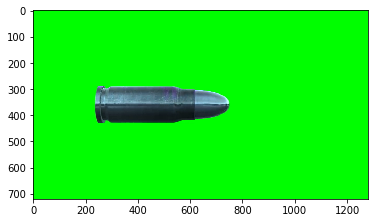

In [446]:
plt.imshow(original_image)

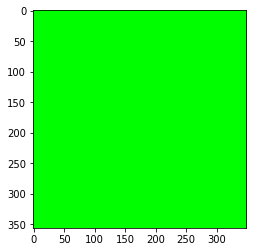

In [447]:
plt.imshow(bg)

In [448]:
hsv_bg = cv2.cvtColor(bg, cv2.COLOR_BGR2HSV)
hue, saturation, value = cv2.split(hsv_bg)
# Histogram 
bg_hist = cv2.calcHist([hsv_bg], [0, 1], None, [180, 256], [0, 180, 0, 256])
mask = cv2.calcBackProject([hsv_original], [0, 1], bg_hist, [0, 180, 0, 256], 1) 
# Filtering remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.filter2D(mask, -1, kernel)
_, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
mask = cv2.merge((mask, mask, mask))
result = cv2.bitwise_and(original_image, mask)


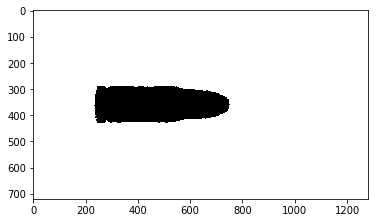

In [449]:
plt.imshow(mask)

L'ouverture 

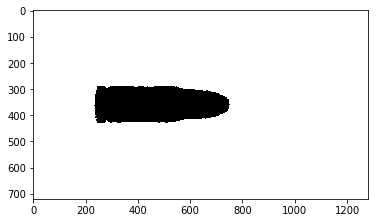

In [450]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
plt.imshow(mask)

Cette fonction constitue le contour à partir du mask

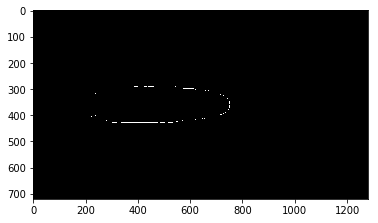

In [451]:
def ctr(mask):
        ctr = np.zeros(mask.shape)   #image noire     
        for px in range(mask.shape[0]): 
            for py in range(mask.shape[1]):
                if(sum(mask[px, py]) == 0 and py > 1 and sum(mask[px, py-1]) == 255*3  and sum(mask[px, py - 2]) == 255*3 ):
                    ctr[px,py-1]=np.array([1, 1, 1])
                if(sum(mask[px, py]) == 0 and py < mask.shape[1]-1 and sum(mask[px, py+1]) == 255*3  and sum(mask[px, py + 2]) == 255*3):
                    ctr[px,py+1]=np.array([1, 1, 1])
                
        for py in range(mask.shape[1]):
            for px in range(mask.shape[0]):
                if(sum(mask[px, py]) == 0 and px > 1 and sum(mask[px-1, py]) == 255*3 and sum(mask[px - 2, py]) == 255*3 ):
                    ctr[px-1,py]=np.array([1, 1, 1])
                if(sum(mask[px, py]) == 0 and px < mask.shape[0]-1 and sum(mask[px+1, py]) == 255*3  and sum(mask[px+ 2, py ]) == 255*3):
                    ctr[px+1,py]=np.array([1, 1, 1])
        return(ctr)
ctr=ctr(mask)
plt.imshow(ctr)

Cette fonction retourne l'histogramme associé au domaine à tracker

In [452]:
def frequence(mask,im,k):
    frequence=dict()
    for px in range(mask.shape[0]):
        for py in range(mask.shape[1]):
            n=mask[px,py]
            n1=(n[0]//k)*k
            n2=(n[1]//k)*k
            n3=(n[2]//k)*k
            if sum(mask[px,py])==0:
                n=im[px,py]
                n1=(n[0]//k)*k
                n2=(n[1]//k)*k
                n3=(n[2]//k)*k
                if (n1,n2,n3) in frequence:
                    frequence[(n1,n2,n3)]+=1
                else:
                    frequence[(n1,n2,n3)]=1
    return frequence


Application sur notre cas

In [453]:
frequence0=frequence(mask,original_image,5)

L'idée est d'évaluer le signe de (q(Z) - lambda) au niveau d'un certain nombre de pixels et de translater le contour vers la gauche ou vers la droite selon le signe. lambda=(1/2)min_q(z)>0 q(z) . Dans notre cas, frequence0 joue le rôle de q. En effet, l'objet qu'on traque est indéformable et fait une translation sur le même plan. Il couvre donc le même nombre de pixels.
En plus dans notre cas,  q(z)> lambda est équivalent à dire que z est dans le dictionnaire frequence0

In [454]:
def deplace_ctr(ctr,frame,n):
    ctr2=np.zeros(ctr.shape)
    for px in range(ctr.shape[0]):
        for py in range(ctr.shape[1]):
            if sum(ctr[px,py])==3:
                ctr2[px,py+n]=ctr[px,py]
                frame[px,py+n]=np.array([  254, 0,   0])
    return(ctr2,frame)

La fonction ci-dessus permet de translater le contour de n fois vers la gauche ou vers la droite selon le signe de n, et trace le contour sur l'image

In [455]:
def ctr_pixels(ctr,nb_pixel):
    Boolean=[True]*nb_pixel
    b=True
    l=0
    for i in Boolean:
        b=b or Boolean[i]
    pixels=[]
    py=ctr.shape[1]-2
    while py!=0 and b:
        px=ctr.shape[0]-1
        b2=True
        while px!=-1 and b and b2:
            if sum(ctr[px,py])==3 and sum(ctr[px,py+1])==0:
                Boolean[l]=False
                l+=1
                b2=False
                if l==len(Boolean):
                    b=False
                pixels.append([px,py])
            px=px-1
        for i in Boolean:
            b=b or Boolean[i]
        py=py-1
    return(pixels)
            

In [456]:
def nbr_deplacement(ctr,pixels,frame,frequence0,k):
    nbr=[]
    for p in pixels:
        s=frame[p[0],p[1]]
        s1=(s[0]//k)*k
        s2=(s[1]//k)*k
        s3=(s[2]//k)*k
        nb_deplace=0
        print(s1,s2,s3)
        if (s1,s2,s3) in frequence0:
            nb_deplace+=1
            print(p,"deplacement droite")
            bl=True
            i=1
            while bl and p[1]+i!=frame.shape[1]:
                s=frame[p[0],p[1]+i]
                s1=(s[0]//k)*k
                s2=(s[1]//k)*k
                s3=(s[2]//k)*k
                i+=1
                if (s1,s2,s3) in frequence0:
                    print(p,"deplacement droite")
                    nb_deplace+=1
                else:
                    bl=False
        
        else:
            nb_deplace+=0
            print(p,"deplacement gauche")
            bl=True
            i=-1
            while bl and p[1]+i!=0:
                s=frame[p[0],p[1]+i]
                s1=(s[0]//k)*k
                s2=(s[1]//k)*k
                s3=(s[2]//k)*k
                if (s1,s2,s3) not in frequence0:
                    print(p,"deplacement gauche")
                    nb_deplace+=-1
                else:
                    bl=False
                i=i-1
        nbr.append(nb_deplace)    
    return int(np.median(nbr))+1

In [457]:
nmax_frame=200
nb_pixels_eval=50
taille_inteval=5

0
20 185 30
[362, 752] deplacement gauche
[362, 752] deplacement gauche
[362, 752] deplacement gauche
30 120 50
[363, 751] deplacement droite
25 225 40
[374, 750] deplacement gauche
50 185 85
[375, 749] deplacement droite
30 205 45
[377, 748] deplacement droite
[377, 748] deplacement droite
45 190 65
[378, 747] deplacement droite
25 220 30
[380, 746] deplacement droite
[380, 746] deplacement droite
50 190 80
[381, 745] deplacement droite
[381, 745] deplacement droite
[381, 745] deplacement droite
25 220 35
[382, 744] deplacement droite
[382, 744] deplacement droite
60 185 90
[383, 743] deplacement droite
[383, 743] deplacement droite
15 225 20
[384, 742] deplacement droite
[384, 742] deplacement droite
60 190 75
[385, 741] deplacement droite
[385, 741] deplacement droite
[385, 741] deplacement droite
30 220 30
[386, 740] deplacement droite
[386, 740] deplacement droite
60 195 70
[387, 739] deplacement droite
[387, 739] deplacement droite
[387, 739] deplacement droite
[387, 739] deplace

[397, 725] deplacement gauche
30 235 20
[398, 723] deplacement gauche
[398, 723] deplacement gauche
[398, 723] deplacement gauche
[398, 723] deplacement gauche
[398, 723] deplacement gauche
165 250 245
[322, 721] deplacement droite
155 255 200
[321, 719] deplacement gauche
[321, 719] deplacement gauche
55 90 90
[399, 715] deplacement droite
[399, 715] deplacement droite
[399, 715] deplacement droite
[399, 715] deplacement droite
15 160 35
[400, 714] deplacement gauche
[400, 714] deplacement gauche
[400, 714] deplacement gauche
65 150 90
[401, 713] deplacement droite
[401, 713] deplacement droite
25 210 40
[402, 711] deplacement droite
60 150 85
[403, 707] deplacement gauche
[403, 707] deplacement gauche
[403, 707] deplacement gauche
[403, 707] deplacement gauche
15 220 25
[404, 705] deplacement gauche
[404, 705] deplacement gauche
[404, 705] deplacement gauche
[404, 705] deplacement gauche
[404, 705] deplacement gauche
[404, 705] deplacement gauche
[404, 705] deplacement gauche
[404, 7

4
15 110 35
[362, 758] deplacement gauche
[362, 758] deplacement gauche
55 115 80
[363, 757] deplacement droite
[363, 757] deplacement droite
30 150 70
[374, 756] deplacement gauche
55 115 100
[375, 755] deplacement gauche
45 135 90
[377, 754] deplacement gauche
[377, 754] deplacement gauche
55 125 95
[378, 753] deplacement droite
25 155 55
[380, 752] deplacement gauche
[380, 752] deplacement gauche
[380, 752] deplacement gauche
60 110 115
[381, 751] deplacement gauche
[381, 751] deplacement gauche
[381, 751] deplacement gauche
30 125 85
[382, 750] deplacement gauche
55 115 85
[383, 749] deplacement droite
25 140 60
[384, 748] deplacement gauche
[384, 748] deplacement gauche
[384, 748] deplacement gauche
60 115 100
[385, 747] deplacement gauche
25 155 35
[386, 746] deplacement gauche
60 130 85
[387, 745] deplacement gauche
[387, 745] deplacement gauche
15 165 35
[388, 744] deplacement gauche
[388, 744] deplacement gauche
[388, 744] deplacement gauche
50 135 85
[389, 743] deplacement ga

[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671] deplacement droite
[305, 671]

7
80 120 120
[362, 762] deplacement droite
[362, 762] deplacement droite
110 140 155
[363, 761] deplacement droite
[363, 761] deplacement droite
[363, 761] deplacement droite
40 95 100
[374, 760] deplacement gauche
[374, 760] deplacement gauche
[374, 760] deplacement gauche
45 85 80
[375, 759] deplacement droite
50 75 110
[377, 758] deplacement gauche
55 80 80
[378, 757] deplacement droite
45 85 95
[380, 756] deplacement droite
[380, 756] deplacement droite
[380, 756] deplacement droite
60 85 85
[381, 755] deplacement droite
[381, 755] deplacement droite
[381, 755] deplacement droite
45 95 75
[382, 754] deplacement droite
[382, 754] deplacement droite
65 85 85
[383, 753] deplacement droite
[383, 753] deplacement droite
[383, 753] deplacement droite
40 85 85
[384, 752] deplacement gauche
60 90 90
[385, 751] deplacement gauche
40 100 70
[386, 750] deplacement droite
55 80 100
[387, 749] deplacement droite
25 100 70
[388, 748] deplacement gauche
45 90 80
[389, 747] deplacement gauche
40 8

9
80 115 120
[362, 766] deplacement droite
[362, 766] deplacement droite
115 135 155
[363, 765] deplacement gauche
40 90 95
[374, 764] deplacement gauche
45 80 80
[375, 763] deplacement droite
50 80 110
[377, 762] deplacement gauche
55 80 80
[378, 761] deplacement droite
45 90 95
[380, 760] deplacement droite
[380, 760] deplacement droite
[380, 760] deplacement droite
60 85 85
[381, 759] deplacement droite
[381, 759] deplacement droite
[381, 759] deplacement droite
45 95 75
[382, 758] deplacement droite
[382, 758] deplacement droite
65 85 85
[383, 757] deplacement droite
[383, 757] deplacement droite
[383, 757] deplacement droite
40 85 85
[384, 756] deplacement gauche
60 90 90
[385, 755] deplacement gauche
40 100 70
[386, 754] deplacement droite
55 80 100
[387, 753] deplacement droite
25 100 65
[388, 752] deplacement gauche
45 90 80
[389, 751] deplacement gauche
40 80 70
[390, 749] deplacement droite
165 245 230
[329, 748] deplacement gauche
50 80 80
[391, 747] deplacement droite
[391,

11
90 120 125
[362, 770] deplacement droite
[362, 770] deplacement droite
115 135 155
[363, 769] deplacement gauche
[363, 769] deplacement gauche
40 90 90
[374, 768] deplacement gauche
45 75 75
[375, 767] deplacement droite
50 75 100
[377, 766] deplacement droite
[377, 766] deplacement droite
50 75 80
[378, 765] deplacement droite
[378, 765] deplacement droite
45 85 90
[380, 764] deplacement gauche
60 85 80
[381, 763] deplacement droite
[381, 763] deplacement droite
[381, 763] deplacement droite
45 90 75
[382, 762] deplacement gauche
60 85 85
[383, 761] deplacement droite
[383, 761] deplacement droite
[383, 761] deplacement droite
40 85 85
[384, 760] deplacement gauche
60 90 85
[385, 759] deplacement droite
40 95 70
[386, 758] deplacement droite
55 75 100
[387, 757] deplacement droite
[387, 757] deplacement droite
25 95 70
[388, 756] deplacement gauche
[388, 756] deplacement gauche
[388, 756] deplacement gauche
45 85 80
[389, 755] deplacement droite
40 80 70
[390, 753] deplacement droi

13
95 125 135
[362, 774] deplacement droite
[362, 774] deplacement droite
115 135 150
[363, 773] deplacement droite
[363, 773] deplacement droite
[363, 773] deplacement droite
40 85 90
[374, 772] deplacement gauche
40 70 70
[375, 771] deplacement droite
[375, 771] deplacement droite
45 70 95
[377, 770] deplacement droite
[377, 770] deplacement droite
50 70 75
[378, 769] deplacement droite
[378, 769] deplacement droite
[378, 769] deplacement droite
40 80 85
[380, 768] deplacement droite
[380, 768] deplacement droite
[380, 768] deplacement droite
55 80 80
[381, 767] deplacement droite
[381, 767] deplacement droite
[381, 767] deplacement droite
45 90 70
[382, 766] deplacement gauche
60 80 85
[383, 765] deplacement droite
40 85 80
[384, 764] deplacement droite
60 90 85
[385, 763] deplacement droite
40 95 70
[386, 762] deplacement droite
55 80 100
[387, 761] deplacement droite
25 100 65
[388, 760] deplacement gauche
45 85 80
[389, 759] deplacement droite
40 80 70
[390, 757] deplacement droi

16
95 125 135
[362, 780] deplacement droite
[362, 780] deplacement droite
115 135 150
[363, 779] deplacement droite
[363, 779] deplacement droite
[363, 779] deplacement droite
40 85 85
[374, 778] deplacement gauche
45 70 70
[375, 777] deplacement droite
[375, 777] deplacement droite
[375, 777] deplacement droite
45 70 100
[377, 776] deplacement droite
45 70 80
[378, 775] deplacement droite
40 80 90
[380, 774] deplacement droite
[380, 774] deplacement droite
50 80 80
[381, 773] deplacement droite
[381, 773] deplacement droite
[381, 773] deplacement droite
40 85 75
[382, 772] deplacement droite
55 80 85
[383, 771] deplacement droite
45 85 85
[384, 770] deplacement droite
60 85 85
[385, 769] deplacement droite
35 90 70
[386, 768] deplacement gauche
55 75 95
[387, 767] deplacement droite
25 95 70
[388, 766] deplacement gauche
50 90 85
[389, 765] deplacement droite
[389, 765] deplacement droite
45 85 75
[390, 763] deplacement droite
160 235 230
[329, 762] deplacement droite
50 80 80
[391, 7

19
95 130 135
[362, 786] deplacement droite
[362, 786] deplacement droite
110 130 150
[363, 785] deplacement droite
[363, 785] deplacement droite
[363, 785] deplacement droite
40 80 80
[374, 784] deplacement droite
40 65 70
[375, 783] deplacement droite
[375, 783] deplacement droite
40 65 90
[377, 782] deplacement gauche
40 65 75
[378, 781] deplacement droite
35 80 85
[380, 780] deplacement gauche
45 75 80
[381, 779] deplacement droite
[381, 779] deplacement droite
[381, 779] deplacement droite
40 80 75
[382, 778] deplacement gauche
55 80 85
[383, 777] deplacement droite
[383, 777] deplacement droite
45 80 85
[384, 776] deplacement droite
[384, 776] deplacement droite
55 85 80
[385, 775] deplacement droite
[385, 775] deplacement droite
35 85 75
[386, 774] deplacement gauche
50 75 95
[387, 773] deplacement droite
[387, 773] deplacement droite
[387, 773] deplacement droite
[387, 773] deplacement droite
25 95 70
[388, 772] deplacement gauche
50 85 80
[389, 771] deplacement droite
45 80 75

21
100 130 140
[362, 790] deplacement droite
[362, 790] deplacement droite
110 130 150
[363, 789] deplacement droite
[363, 789] deplacement droite
[363, 789] deplacement droite
40 75 80
[374, 788] deplacement droite
[374, 788] deplacement droite
35 60 65
[375, 787] deplacement droite
[375, 787] deplacement droite
[375, 787] deplacement droite
40 60 85
[377, 786] deplacement gauche
40 65 70
[378, 785] deplacement droite
35 75 85
[380, 784] deplacement droite
[380, 784] deplacement droite
45 75 75
[381, 783] deplacement droite
[381, 783] deplacement droite
[381, 783] deplacement droite
40 80 70
[382, 782] deplacement droite
[382, 782] deplacement droite
50 75 80
[383, 781] deplacement droite
[383, 781] deplacement droite
45 80 85
[384, 780] deplacement droite
[384, 780] deplacement droite
55 85 80
[385, 779] deplacement droite
[385, 779] deplacement droite
35 85 75
[386, 778] deplacement gauche
50 75 95
[387, 777] deplacement droite
[387, 777] deplacement droite
[387, 777] deplacement dr

23
100 130 140
[362, 794] deplacement droite
[362, 794] deplacement droite
[362, 794] deplacement droite
[362, 794] deplacement droite
105 125 145
[363, 793] deplacement gauche
35 75 75
[374, 792] deplacement droite
[374, 792] deplacement droite
35 55 65
[375, 791] deplacement droite
[375, 791] deplacement droite
[375, 791] deplacement droite
35 60 80
[377, 790] deplacement droite
[377, 790] deplacement droite
35 65 70
[378, 789] deplacement droite
[378, 789] deplacement droite
[378, 789] deplacement droite
35 75 80
[380, 788] deplacement gauche
45 70 75
[381, 787] deplacement droite
40 80 70
[382, 786] deplacement droite
[382, 786] deplacement droite
45 75 75
[383, 785] deplacement droite
[383, 785] deplacement droite
[383, 785] deplacement droite
45 80 80
[384, 784] deplacement droite
[384, 784] deplacement droite
50 80 80
[385, 783] deplacement droite
[385, 783] deplacement droite
35 85 75
[386, 782] deplacement gauche
50 70 90
[387, 781] deplacement droite
30 90 70
[388, 780] depla

25
105 130 140
[362, 798] deplacement gauche
[362, 798] deplacement gauche
110 125 145
[363, 797] deplacement gauche
35 70 70
[374, 796] deplacement droite
[374, 796] deplacement droite
35 55 60
[375, 795] deplacement droite
[375, 795] deplacement droite
35 60 75
[377, 794] deplacement droite
[377, 794] deplacement droite
35 60 70
[378, 793] deplacement droite
30 70 75
[380, 792] deplacement gauche
40 65 75
[381, 791] deplacement droite
35 75 70
[382, 790] deplacement droite
[382, 790] deplacement droite
45 70 75
[383, 789] deplacement droite
[383, 789] deplacement droite
[383, 789] deplacement droite
[383, 789] deplacement droite
40 80 80
[384, 788] deplacement droite
[384, 788] deplacement droite
55 80 80
[385, 787] deplacement droite
[385, 787] deplacement droite
[385, 787] deplacement droite
35 85 70
[386, 786] deplacement droite
[386, 786] deplacement droite
[386, 786] deplacement droite
50 70 90
[387, 785] deplacement droite
30 90 70
[388, 784] deplacement gauche
50 85 80
[389, 7

27
100 125 135
[362, 803] deplacement droite
[362, 803] deplacement droite
[362, 803] deplacement droite
115 140 150
[363, 802] deplacement droite
[363, 802] deplacement droite
[363, 802] deplacement droite
50 85 85
[374, 801] deplacement droite
40 75 75
[375, 800] deplacement droite
50 75 90
[377, 799] deplacement droite
35 75 75
[378, 798] deplacement droite
[378, 798] deplacement droite
45 80 85
[380, 797] deplacement droite
45 80 85
[381, 796] deplacement droite
[381, 796] deplacement droite
45 85 80
[382, 795] deplacement droite
[382, 795] deplacement droite
[382, 795] deplacement droite
45 85 80
[383, 794] deplacement droite
[383, 794] deplacement droite
50 85 85
[384, 793] deplacement droite
50 90 90
[385, 792] deplacement droite
[385, 792] deplacement droite
50 90 85
[386, 791] deplacement droite
50 90 85
[387, 790] deplacement droite
[387, 790] deplacement droite
40 90 75
[388, 789] deplacement droite
40 95 80
[389, 788] deplacement gauche
35 95 60
[390, 786] deplacement gauch

29
100 125 135
[362, 807] deplacement droite
110 135 145
[363, 806] deplacement droite
[363, 806] deplacement droite
[363, 806] deplacement droite
[363, 806] deplacement droite
50 80 85
[374, 805] deplacement droite
40 70 75
[375, 804] deplacement droite
[375, 804] deplacement droite
45 65 85
[377, 803] deplacement droite
35 70 75
[378, 802] deplacement droite
[378, 802] deplacement droite
45 80 80
[380, 801] deplacement droite
40 75 80
[381, 800] deplacement droite
[381, 800] deplacement droite
[381, 800] deplacement droite
45 80 80
[382, 799] deplacement droite
45 80 80
[383, 798] deplacement droite
50 85 85
[384, 797] deplacement droite
50 85 90
[385, 796] deplacement droite
50 85 80
[386, 795] deplacement droite
50 85 80
[387, 794] deplacement droite
[387, 794] deplacement droite
40 90 75
[388, 793] deplacement droite
45 95 80
[389, 792] deplacement droite
[389, 792] deplacement droite
40 90 65
[390, 790] deplacement droite
165 235 240
[329, 789] deplacement droite
[329, 789] depla

31
100 125 135
[362, 811] deplacement droite
110 135 145
[363, 810] deplacement droite
[363, 810] deplacement droite
[363, 810] deplacement droite
[363, 810] deplacement droite
50 80 85
[374, 809] deplacement droite
[374, 809] deplacement droite
40 70 75
[375, 808] deplacement droite
[375, 808] deplacement droite
45 65 85
[377, 807] deplacement droite
35 70 70
[378, 806] deplacement droite
[378, 806] deplacement droite
45 80 80
[380, 805] deplacement droite
40 75 80
[381, 804] deplacement droite
[381, 804] deplacement droite
[381, 804] deplacement droite
45 80 75
[382, 803] deplacement droite
45 80 80
[383, 802] deplacement droite
50 85 85
[384, 801] deplacement droite
50 85 90
[385, 800] deplacement droite
50 85 80
[386, 799] deplacement droite
50 85 80
[387, 798] deplacement droite
[387, 798] deplacement droite
40 90 75
[388, 797] deplacement droite
45 95 80
[389, 796] deplacement droite
[389, 796] deplacement droite
40 95 60
[390, 794] deplacement gauche
165 235 240
[329, 793] depla

33
100 130 135
[362, 815] deplacement droite
[362, 815] deplacement droite
[362, 815] deplacement droite
105 135 145
[363, 814] deplacement droite
[363, 814] deplacement droite
[363, 814] deplacement droite
[363, 814] deplacement droite
[363, 814] deplacement droite
[363, 814] deplacement droite
45 80 80
[374, 813] deplacement droite
35 65 70
[375, 812] deplacement droite
[375, 812] deplacement droite
40 60 80
[377, 811] deplacement droite
35 65 70
[378, 810] deplacement droite
[378, 810] deplacement droite
40 75 80
[380, 809] deplacement droite
40 70 75
[381, 808] deplacement droite
[381, 808] deplacement droite
40 75 75
[382, 807] deplacement droite
45 80 75
[383, 806] deplacement droite
50 80 85
[384, 805] deplacement droite
50 85 85
[385, 804] deplacement droite
[385, 804] deplacement droite
50 80 80
[386, 803] deplacement droite
50 85 85
[387, 802] deplacement droite
40 90 75
[388, 801] deplacement droite
45 90 80
[389, 800] deplacement gauche
40 90 65
[390, 798] deplacement droit

35
105 130 135
[362, 819] deplacement droite
110 135 140
[363, 818] deplacement droite
[363, 818] deplacement droite
[363, 818] deplacement droite
[363, 818] deplacement droite
40 70 75
[374, 817] deplacement droite
30 60 65
[375, 816] deplacement droite
[375, 816] deplacement droite
[375, 816] deplacement droite
40 60 75
[377, 815] deplacement droite
30 65 65
[378, 814] deplacement droite
[378, 814] deplacement droite
35 65 70
[380, 813] deplacement droite
35 65 70
[381, 812] deplacement droite
[381, 812] deplacement droite
35 70 70
[382, 811] deplacement droite
40 70 70
[383, 810] deplacement droite
[383, 810] deplacement droite
45 80 75
[384, 809] deplacement droite
45 85 75
[385, 808] deplacement droite
[385, 808] deplacement droite
50 85 80
[386, 807] deplacement droite
50 85 80
[387, 806] deplacement droite
40 90 75
[388, 805] deplacement droite
45 90 80
[389, 804] deplacement gauche
40 90 65
[390, 802] deplacement droite
160 230 240
[329, 801] deplacement droite
[329, 801] depla

38
105 130 135
[362, 825] deplacement droite
[362, 825] deplacement droite
[362, 825] deplacement droite
105 130 135
[363, 824] deplacement droite
[363, 824] deplacement droite
40 70 65
[374, 823] deplacement droite
[374, 823] deplacement droite
25 60 55
[375, 822] deplacement gauche
35 60 75
[377, 821] deplacement droite
[377, 821] deplacement droite
30 60 60
[378, 820] deplacement droite
[378, 820] deplacement droite
35 65 70
[380, 819] deplacement droite
30 60 65
[381, 818] deplacement droite
[381, 818] deplacement droite
[381, 818] deplacement droite
[381, 818] deplacement droite
35 65 65
[382, 817] deplacement droite
[382, 817] deplacement droite
[382, 817] deplacement droite
[382, 817] deplacement droite
[382, 817] deplacement droite
35 65 65
[383, 816] deplacement droite
[383, 816] deplacement droite
[383, 816] deplacement droite
[383, 816] deplacement droite
45 80 75
[384, 815] deplacement droite
45 80 75
[385, 814] deplacement droite
45 85 80
[386, 813] deplacement droite
45 8

40
90 125 125
[362, 830] deplacement droite
[362, 830] deplacement droite
115 140 150
[363, 829] deplacement droite
35 100 70
[374, 828] deplacement droite
45 80 70
[375, 827] deplacement gauche
[375, 827] deplacement gauche
40 90 70
[377, 826] deplacement droite
40 75 75
[378, 825] deplacement droite
30 95 70
[380, 824] deplacement gauche
50 80 85
[381, 823] deplacement droite
[381, 823] deplacement droite
[381, 823] deplacement droite
35 90 75
[382, 822] deplacement droite
[382, 822] deplacement droite
[382, 822] deplacement droite
[382, 822] deplacement droite
50 85 85
[383, 821] deplacement droite
[383, 821] deplacement droite
[383, 821] deplacement droite
35 95 80
[384, 820] deplacement gauche
60 90 85
[385, 819] deplacement droite
[385, 819] deplacement droite
[385, 819] deplacement droite
35 100 65
[386, 818] deplacement droite
50 90 85
[387, 817] deplacement droite
25 115 50
[388, 816] deplacement gauche
50 95 85
[389, 815] deplacement gauche
45 95 65
[390, 813] deplacement gau

42
95 130 130
[362, 834] deplacement droite
115 140 150
[363, 833] deplacement droite
30 95 65
[374, 832] deplacement droite
40 70 65
[375, 831] deplacement droite
35 85 70
[377, 830] deplacement droite
[377, 830] deplacement droite
40 75 75
[378, 829] deplacement droite
30 90 70
[380, 828] deplacement gauche
45 75 80
[381, 827] deplacement droite
[381, 827] deplacement droite
[381, 827] deplacement droite
35 80 70
[382, 826] deplacement droite
[382, 826] deplacement droite
50 80 80
[383, 825] deplacement droite
35 90 75
[384, 824] deplacement droite
55 90 85
[385, 823] deplacement gauche
35 100 65
[386, 822] deplacement droite
50 85 80
[387, 821] deplacement droite
25 105 50
[388, 820] deplacement gauche
50 95 80
[389, 819] deplacement gauche
40 90 65
[390, 817] deplacement droite
160 245 230
[329, 816] deplacement droite
[329, 816] deplacement droite
50 80 75
[391, 815] deplacement droite
[391, 815] deplacement droite
40 90 85
[392, 813] deplacement gauche
[392, 813] deplacement gauc

45
95 135 125
[362, 840] deplacement gauche
115 140 145
[363, 839] deplacement droite
30 90 65
[374, 838] deplacement gauche
40 65 65
[375, 837] deplacement droite
[375, 837] deplacement droite
35 80 65
[377, 836] deplacement gauche
35 70 70
[378, 835] deplacement droite
25 85 65
[380, 834] deplacement gauche
40 70 75
[381, 833] deplacement droite
30 75 70
[382, 832] deplacement gauche
45 75 75
[383, 831] deplacement droite
30 85 70
[384, 830] deplacement gauche
50 85 80
[385, 829] deplacement droite
35 95 65
[386, 828] deplacement droite
[386, 828] deplacement droite
50 80 80
[387, 827] deplacement droite
[387, 827] deplacement droite
[387, 827] deplacement droite
[387, 827] deplacement droite
25 105 50
[388, 826] deplacement gauche
[388, 826] deplacement gauche
[388, 826] deplacement gauche
50 90 80
[389, 825] deplacement droite
40 85 65
[390, 823] deplacement gauche
[390, 823] deplacement gauche
160 245 230
[329, 822] deplacement droite
[329, 822] deplacement droite
45 80 75
[391, 8

47
95 135 120
[362, 844] deplacement gauche
115 140 145
[363, 843] deplacement droite
30 85 60
[374, 842] deplacement gauche
35 65 60
[375, 841] deplacement droite
[375, 841] deplacement droite
[375, 841] deplacement droite
[375, 841] deplacement droite
30 75 65
[377, 840] deplacement gauche
35 65 70
[378, 839] deplacement droite
25 80 65
[380, 838] deplacement gauche
40 65 70
[381, 837] deplacement droite
25 70 65
[382, 836] deplacement droite
[382, 836] deplacement droite
40 70 70
[383, 835] deplacement droite
35 90 75
[384, 834] deplacement droite
55 85 80
[385, 833] deplacement droite
35 95 65
[386, 832] deplacement droite
[386, 832] deplacement droite
50 80 80
[387, 831] deplacement droite
[387, 831] deplacement droite
[387, 831] deplacement droite
[387, 831] deplacement droite
25 105 55
[388, 830] deplacement gauche
[388, 830] deplacement gauche
50 90 80
[389, 829] deplacement droite
40 85 65
[390, 827] deplacement gauche
[390, 827] deplacement gauche
160 245 225
[329, 826] depla

49
100 135 120
[362, 848] deplacement gauche
110 135 140
[363, 847] deplacement droite
30 80 60
[374, 846] deplacement gauche
35 60 60
[375, 845] deplacement droite
[375, 845] deplacement droite
[375, 845] deplacement droite
30 70 60
[377, 844] deplacement gauche
35 65 65
[378, 843] deplacement droite
25 75 60
[380, 842] deplacement gauche
35 65 70
[381, 841] deplacement droite
[381, 841] deplacement droite
25 70 60
[382, 840] deplacement droite
[382, 840] deplacement droite
35 65 65
[383, 839] deplacement droite
[383, 839] deplacement droite
35 85 75
[384, 838] deplacement gauche
50 85 80
[385, 837] deplacement droite
35 90 65
[386, 836] deplacement droite
[386, 836] deplacement droite
[386, 836] deplacement droite
[386, 836] deplacement droite
50 80 80
[387, 835] deplacement droite
[387, 835] deplacement droite
[387, 835] deplacement droite
[387, 835] deplacement droite
25 100 55
[388, 834] deplacement gauche
50 90 75
[389, 833] deplacement gauche
40 85 65
[390, 831] deplacement gauc

51
100 125 130
[362, 851] deplacement droite
95 120 125
[363, 850] deplacement droite
[363, 850] deplacement droite
35 60 60
[374, 849] deplacement droite
25 55 50
[375, 848] deplacement gauche
30 50 65
[377, 847] deplacement droite
25 55 55
[378, 846] deplacement gauche
30 55 60
[380, 845] deplacement droite
25 50 55
[381, 844] deplacement droite
[381, 844] deplacement droite
[381, 844] deplacement droite
25 55 55
[382, 843] deplacement gauche
[382, 843] deplacement gauche
20 55 55
[383, 842] deplacement droite
[383, 842] deplacement droite
[383, 842] deplacement droite
35 65 65
[384, 841] deplacement droite
35 70 65
[385, 840] deplacement droite
[385, 840] deplacement droite
40 70 70
[386, 839] deplacement droite
[386, 839] deplacement droite
[386, 839] deplacement droite
[386, 839] deplacement droite
[386, 839] deplacement droite
40 70 75
[387, 838] deplacement droite
[387, 838] deplacement droite
[387, 838] deplacement droite
[387, 838] deplacement droite
[387, 838] deplacement dro

155 240 255
[308, 772] deplacement gauche
[308, 772] deplacement gauche
[308, 772] deplacement gauche
55 255 55
[307, 771] deplacement gauche
[307, 771] deplacement gauche
[307, 771] deplacement gauche
[307, 771] deplacement gauche
[307, 771] deplacement gauche
[307, 771] deplacement gauche
[307, 771] deplacement gauche
[307, 771] deplacement gauche
50 90 90
[411, 770] deplacement droite
[411, 770] deplacement droite
15 190 10
[412, 768] deplacement gauche
[412, 768] deplacement gauche
[412, 768] deplacement gauche
[412, 768] deplacement gauche
[412, 768] deplacement gauche
[412, 768] deplacement gauche
[412, 768] deplacement gauche
[412, 768] deplacement gauche
0 255 0
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacement gauche
[305, 766] deplacemen

54
95 120 125
[362, 857] deplacement droite
90 115 120
[363, 856] deplacement droite
[363, 856] deplacement droite
30 55 60
[374, 855] deplacement droite
25 50 50
[375, 854] deplacement droite
[375, 854] deplacement droite
30 50 60
[377, 853] deplacement droite
[377, 853] deplacement droite
[377, 853] deplacement droite
25 55 55
[378, 852] deplacement gauche
25 55 60
[380, 851] deplacement droite
20 50 55
[381, 850] deplacement droite
[381, 850] deplacement droite
[381, 850] deplacement droite
[381, 850] deplacement droite
20 55 55
[382, 849] deplacement droite
25 55 55
[383, 848] deplacement gauche
30 55 60
[384, 847] deplacement droite
30 60 60
[385, 846] deplacement droite
[385, 846] deplacement droite
35 60 65
[386, 845] deplacement droite
[386, 845] deplacement droite
[386, 845] deplacement droite
40 65 70
[387, 844] deplacement droite
[387, 844] deplacement droite
[387, 844] deplacement droite
[387, 844] deplacement droite
40 75 70
[388, 843] deplacement droite
[388, 843] deplace

56
95 135 125
[362, 862] deplacement gauche
100 130 135
[363, 861] deplacement droite
25 75 55
[374, 860] deplacement gauche
30 55 55
[375, 859] deplacement droite
35 65 55
[377, 858] deplacement droite
[377, 858] deplacement droite
35 60 55
[378, 857] deplacement droite
25 65 65
[380, 856] deplacement gauche
35 55 65
[381, 855] deplacement droite
[381, 855] deplacement droite
25 65 55
[382, 854] deplacement gauche
40 65 65
[383, 853] deplacement droite
[383, 853] deplacement droite
[383, 853] deplacement droite
[383, 853] deplacement droite
30 75 70
[384, 852] deplacement gauche
45 75 75
[385, 851] deplacement droite
35 85 65
[386, 850] deplacement droite
[386, 850] deplacement droite
45 70 80
[387, 849] deplacement droite
[387, 849] deplacement droite
[387, 849] deplacement droite
30 95 60
[388, 848] deplacement droite
[388, 848] deplacement droite
45 85 75
[389, 847] deplacement droite
[389, 847] deplacement droite
40 80 70
[390, 845] deplacement droite
170 240 235
[329, 844] deplac

58
90 135 125
[362, 866] deplacement gauche
100 130 135
[363, 865] deplacement droite
25 70 55
[374, 864] deplacement gauche
30 50 55
[375, 863] deplacement droite
35 65 50
[377, 862] deplacement gauche
[377, 862] deplacement gauche
35 60 55
[378, 861] deplacement droite
25 60 60
[380, 860] deplacement gauche
35 55 60
[381, 859] deplacement droite
[381, 859] deplacement droite
[381, 859] deplacement droite
[381, 859] deplacement droite
25 60 55
[382, 858] deplacement gauche
35 60 65
[383, 857] deplacement droite
30 75 70
[384, 856] deplacement gauche
45 75 75
[385, 855] deplacement droite
35 85 65
[386, 854] deplacement droite
[386, 854] deplacement droite
45 70 80
[387, 853] deplacement droite
[387, 853] deplacement droite
[387, 853] deplacement droite
30 95 60
[388, 852] deplacement droite
[388, 852] deplacement droite
45 85 75
[389, 851] deplacement droite
[389, 851] deplacement droite
40 80 70
[390, 849] deplacement droite
170 240 230
[329, 848] deplacement gauche
45 75 75
[391, 84

60
90 135 125
[362, 870] deplacement gauche
100 130 135
[363, 869] deplacement droite
25 70 55
[374, 868] deplacement gauche
30 50 55
[375, 867] deplacement droite
35 65 50
[377, 866] deplacement gauche
[377, 866] deplacement gauche
35 60 55
[378, 865] deplacement droite
25 60 60
[380, 864] deplacement gauche
30 50 60
[381, 863] deplacement droite
[381, 863] deplacement droite
[381, 863] deplacement droite
[381, 863] deplacement droite
25 60 55
[382, 862] deplacement gauche
35 60 60
[383, 861] deplacement droite
[383, 861] deplacement droite
30 75 70
[384, 860] deplacement gauche
45 75 75
[385, 859] deplacement droite
35 85 65
[386, 858] deplacement droite
[386, 858] deplacement droite
45 70 80
[387, 857] deplacement droite
[387, 857] deplacement droite
[387, 857] deplacement droite
30 95 60
[388, 856] deplacement droite
[388, 856] deplacement droite
45 85 75
[389, 855] deplacement droite
[389, 855] deplacement droite
40 80 70
[390, 853] deplacement droite
170 240 230
[329, 852] deplac

62
90 130 125
[362, 874] deplacement droite
[362, 874] deplacement droite
95 125 130
[363, 873] deplacement droite
[363, 873] deplacement droite
[363, 873] deplacement droite
25 65 55
[374, 872] deplacement gauche
25 50 55
[375, 871] deplacement droite
35 60 50
[377, 870] deplacement droite
[377, 870] deplacement droite
30 55 55
[378, 869] deplacement droite
[378, 869] deplacement droite
[378, 869] deplacement droite
30 60 60
[380, 868] deplacement droite
[380, 868] deplacement droite
30 50 60
[381, 867] deplacement droite
[381, 867] deplacement droite
[381, 867] deplacement droite
25 55 50
[382, 866] deplacement gauche
30 55 60
[383, 865] deplacement droite
[383, 865] deplacement droite
[383, 865] deplacement droite
[383, 865] deplacement droite
30 75 65
[384, 864] deplacement gauche
45 70 70
[385, 863] deplacement droite
35 80 65
[386, 862] deplacement gauche
45 70 80
[387, 861] deplacement droite
[387, 861] deplacement droite
[387, 861] deplacement droite
30 90 60
[388, 860] deplace

64
95 130 125
[362, 878] deplacement gauche
95 120 130
[363, 877] deplacement droite
30 50 75
[374, 876] deplacement gauche
25 50 55
[375, 875] deplacement droite
35 60 50
[377, 874] deplacement droite
[377, 874] deplacement droite
30 55 55
[378, 873] deplacement droite
[378, 873] deplacement droite
30 60 60
[380, 872] deplacement droite
[380, 872] deplacement droite
30 50 60
[381, 871] deplacement droite
[381, 871] deplacement droite
[381, 871] deplacement droite
[381, 871] deplacement droite
25 55 50
[382, 870] deplacement gauche
30 55 55
[383, 869] deplacement droite
[383, 869] deplacement droite
[383, 869] deplacement droite
[383, 869] deplacement droite
[383, 869] deplacement droite
30 70 70
[384, 868] deplacement gauche
[384, 868] deplacement gauche
45 70 70
[385, 867] deplacement droite
[385, 867] deplacement droite
[385, 867] deplacement droite
35 70 75
[386, 866] deplacement droite
[386, 866] deplacement droite
45 65 80
[387, 865] deplacement droite
[387, 865] deplacement droi

66
100 120 130
[362, 882] deplacement droite
[362, 882] deplacement droite
[362, 882] deplacement droite
[362, 882] deplacement droite
100 115 130
[363, 881] deplacement gauche
30 50 75
[374, 880] deplacement gauche
25 50 55
[375, 879] deplacement droite
35 60 50
[377, 878] deplacement droite
[377, 878] deplacement droite
30 55 55
[378, 877] deplacement droite
[378, 877] deplacement droite
30 60 60
[380, 876] deplacement droite
[380, 876] deplacement droite
30 50 60
[381, 875] deplacement droite
[381, 875] deplacement droite
[381, 875] deplacement droite
[381, 875] deplacement droite
25 55 50
[382, 874] deplacement gauche
30 55 55
[383, 873] deplacement droite
[383, 873] deplacement droite
[383, 873] deplacement droite
[383, 873] deplacement droite
[383, 873] deplacement droite
30 70 70
[384, 872] deplacement gauche
[384, 872] deplacement gauche
45 70 70
[385, 871] deplacement droite
[385, 871] deplacement droite
[385, 871] deplacement droite
35 70 75
[386, 870] deplacement droite
[386

68
95 120 130
[362, 886] deplacement droite
[362, 886] deplacement droite
[362, 886] deplacement droite
[362, 886] deplacement droite
95 110 125
[363, 885] deplacement gauche
35 50 75
[374, 884] deplacement gauche
30 50 55
[375, 883] deplacement droite
35 55 50
[377, 882] deplacement droite
[377, 882] deplacement droite
35 50 55
[378, 881] deplacement droite
[378, 881] deplacement droite
[378, 881] deplacement droite
30 55 60
[380, 880] deplacement droite
[380, 880] deplacement droite
35 50 60
[381, 879] deplacement droite
[381, 879] deplacement droite
[381, 879] deplacement droite
[381, 879] deplacement droite
25 55 55
[382, 878] deplacement gauche
30 55 55
[383, 877] deplacement droite
[383, 877] deplacement droite
[383, 877] deplacement droite
[383, 877] deplacement droite
[383, 877] deplacement droite
25 65 65
[384, 876] deplacement gauche
40 65 65
[385, 875] deplacement droite
[385, 875] deplacement droite
[385, 875] deplacement droite
[385, 875] deplacement droite
[385, 875] depl

69
95 120 130
[362, 888] deplacement droite
[362, 888] deplacement droite
[362, 888] deplacement droite
[362, 888] deplacement droite
95 110 125
[363, 887] deplacement gauche
35 50 75
[374, 886] deplacement gauche
30 50 55
[375, 885] deplacement droite
35 55 50
[377, 884] deplacement droite
[377, 884] deplacement droite
[377, 884] deplacement droite
[377, 884] deplacement droite
35 50 60
[378, 883] deplacement droite
[378, 883] deplacement droite
[378, 883] deplacement droite
30 55 60
[380, 882] deplacement droite
[380, 882] deplacement droite
[380, 882] deplacement droite
[380, 882] deplacement droite
[380, 882] deplacement droite
[380, 882] deplacement droite
35 50 60
[381, 881] deplacement droite
[381, 881] deplacement droite
[381, 881] deplacement droite
[381, 881] deplacement droite
25 55 55
[382, 880] deplacement gauche
30 55 55
[383, 879] deplacement droite
[383, 879] deplacement droite
[383, 879] deplacement droite
25 65 65
[384, 878] deplacement gauche
40 65 65
[385, 877] depl

71
95 120 130
[362, 892] deplacement droite
[362, 892] deplacement droite
[362, 892] deplacement droite
[362, 892] deplacement droite
95 110 125
[363, 891] deplacement gauche
35 45 75
[374, 890] deplacement gauche
30 45 55
[375, 889] deplacement droite
35 55 50
[377, 888] deplacement droite
[377, 888] deplacement droite
[377, 888] deplacement droite
[377, 888] deplacement droite
35 50 55
[378, 887] deplacement droite
[378, 887] deplacement droite
[378, 887] deplacement droite
30 50 60
[380, 886] deplacement droite
[380, 886] deplacement droite
[380, 886] deplacement droite
[380, 886] deplacement droite
35 50 60
[381, 885] deplacement droite
[381, 885] deplacement droite
[381, 885] deplacement droite
[381, 885] deplacement droite
[381, 885] deplacement droite
25 55 55
[382, 884] deplacement gauche
30 50 55
[383, 883] deplacement droite
[383, 883] deplacement droite
[383, 883] deplacement droite
[383, 883] deplacement droite
30 65 65
[384, 882] deplacement droite
[384, 882] deplacement d

73
100 125 135
[362, 897] deplacement droite
[362, 897] deplacement droite
[362, 897] deplacement droite
100 125 135
[363, 896] deplacement droite
[363, 896] deplacement droite
[363, 896] deplacement droite
[363, 896] deplacement droite
40 55 80
[374, 895] deplacement gauche
[374, 895] deplacement gauche
30 45 70
[375, 894] deplacement gauche
40 60 55
[377, 893] deplacement droite
[377, 893] deplacement droite
35 60 55
[378, 892] deplacement droite
35 60 65
[380, 891] deplacement droite
[380, 891] deplacement droite
[380, 891] deplacement droite
[380, 891] deplacement droite
35 55 65
[381, 890] deplacement droite
[381, 890] deplacement droite
[381, 890] deplacement droite
30 55 60
[382, 889] deplacement droite
35 60 60
[383, 888] deplacement droite
[383, 888] deplacement droite
40 75 75
[384, 887] deplacement droite
40 75 80
[385, 886] deplacement droite
[385, 886] deplacement droite
[385, 886] deplacement droite
40 75 85
[386, 885] deplacement droite
40 75 80
[387, 884] deplacement dr

[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810] deplacement droite
[305, 810]

[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812] deplacement droite
[305, 812]

75
105 125 135
[362, 901] deplacement gauche
100 120 130
[363, 900] deplacement droite
[363, 900] deplacement droite
[363, 900] deplacement droite
[363, 900] deplacement droite
[363, 900] deplacement droite
[363, 900] deplacement droite
40 55 75
[374, 899] deplacement droite
[374, 899] deplacement droite
[374, 899] deplacement droite
30 45 70
[375, 898] deplacement gauche
40 55 55
[377, 897] deplacement droite
[377, 897] deplacement droite
[377, 897] deplacement droite
35 55 60
[378, 896] deplacement droite
[378, 896] deplacement droite
35 60 65
[380, 895] deplacement droite
[380, 895] deplacement droite
[380, 895] deplacement droite
[380, 895] deplacement droite
30 55 60
[381, 894] deplacement droite
[381, 894] deplacement droite
[381, 894] deplacement droite
30 55 55
[382, 893] deplacement droite
30 60 60
[383, 892] deplacement droite
[383, 892] deplacement droite
40 75 75
[384, 891] deplacement droite
40 75 80
[385, 890] deplacement droite
[385, 890] deplacement droite
[385, 890] de

76
105 125 135
[362, 903] deplacement gauche
100 120 130
[363, 902] deplacement droite
[363, 902] deplacement droite
[363, 902] deplacement droite
[363, 902] deplacement droite
[363, 902] deplacement droite
[363, 902] deplacement droite
40 55 75
[374, 901] deplacement droite
[374, 901] deplacement droite
[374, 901] deplacement droite
30 45 70
[375, 900] deplacement gauche
40 55 55
[377, 899] deplacement droite
[377, 899] deplacement droite
[377, 899] deplacement droite
35 55 60
[378, 898] deplacement droite
[378, 898] deplacement droite
35 60 65
[380, 897] deplacement droite
[380, 897] deplacement droite
[380, 897] deplacement droite
[380, 897] deplacement droite
30 55 60
[381, 896] deplacement droite
[381, 896] deplacement droite
[381, 896] deplacement droite
30 55 55
[382, 895] deplacement droite
30 60 60
[383, 894] deplacement droite
[383, 894] deplacement droite
40 75 75
[384, 893] deplacement droite
40 75 80
[385, 892] deplacement droite
[385, 892] deplacement droite
[385, 892] de

[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
[305, 820] deplacement droite
65 180 70
[413, 816] deplacement gauche
85 195 160
[306, 815] deplacement gauche
[306, 815] deplacement gauche
[306, 815] deplacement gauche
[306, 815] deplacement gauche
[306, 815] deplacement gauche
79
100 120 130
[362, 909] deplacement droite
[362, 909] deplacement droite
[362, 909] deplacement droite
[362, 909] deplacement droite
[362, 909] deplacement droite
[362, 909] deplacement droite
[362, 909] deplacement droite
95 120 130
[363, 908] deplacement droite
35 50 70
[374, 907] dep

80
100 120 130
[362, 911] deplacement droite
[362, 911] deplacement droite
[362, 911] deplacement droite
[362, 911] deplacement droite
[362, 911] deplacement droite
[362, 911] deplacement droite
[362, 911] deplacement droite
95 115 125
[363, 910] deplacement droite
35 50 70
[374, 909] deplacement droite
[374, 909] deplacement droite
30 45 65
[375, 908] deplacement droite
[375, 908] deplacement droite
[375, 908] deplacement droite
[375, 908] deplacement droite
40 55 55
[377, 907] deplacement droite
[377, 907] deplacement droite
[377, 907] deplacement droite
30 50 55
[378, 906] deplacement droite
[378, 906] deplacement droite
35 55 65
[380, 905] deplacement droite
30 50 60
[381, 904] deplacement droite
[381, 904] deplacement droite
[381, 904] deplacement droite
[381, 904] deplacement droite
25 50 55
[382, 903] deplacement droite
[382, 903] deplacement droite
[382, 903] deplacement droite
[382, 903] deplacement droite
[382, 903] deplacement droite
30 55 60
[383, 902] deplacement droite
[3

[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824] deplacement droite
[305, 824]

[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
[305, 826] deplacement droite
65 180 70
[413, 822] deplacement gauche
90 190 170
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacement gauche
[306, 821] deplacem

83
100 125 140
[362, 918] deplacement droite
[362, 918] deplacement droite
[362, 918] deplacement droite
105 130 140
[363, 917] deplacement gauche
25 65 75
[374, 916] deplacement gauche
35 50 70
[375, 915] deplacement droite
35 65 65
[377, 914] deplacement droite
[377, 914] deplacement droite
35 55 60
[378, 913] deplacement droite
35 70 65
[380, 912] deplacement droite
[380, 912] deplacement droite
40 60 70
[381, 911] deplacement droite
[381, 911] deplacement droite
[381, 911] deplacement droite
[381, 911] deplacement droite
25 65 55
[382, 910] deplacement gauche
35 60 60
[383, 909] deplacement droite
[383, 909] deplacement droite
[383, 909] deplacement droite
50 80 75
[384, 908] deplacement droite
[384, 908] deplacement droite
50 85 85
[385, 907] deplacement droite
30 85 85
[386, 906] deplacement gauche
50 80 85
[387, 905] deplacement droite
25 95 65
[388, 904] deplacement gauche
45 85 85
[389, 903] deplacement droite
40 75 80
[390, 901] deplacement droite
165 240 235
[329, 900] depla

[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831] deplacement droite
[305, 831]

85
100 125 140
[362, 922] deplacement droite
[362, 922] deplacement droite
105 125 135
[363, 921] deplacement gauche
25 60 70
[374, 920] deplacement gauche
35 50 70
[375, 919] deplacement droite
[375, 919] deplacement droite
[375, 919] deplacement droite
30 65 60
[377, 918] deplacement droite
[377, 918] deplacement droite
[377, 918] deplacement droite
[377, 918] deplacement droite
[377, 918] deplacement droite
35 55 55
[378, 917] deplacement droite
[378, 917] deplacement droite
[378, 917] deplacement droite
[378, 917] deplacement droite
30 65 65
[380, 916] deplacement droite
[380, 916] deplacement droite
40 55 65
[381, 915] deplacement droite
[381, 915] deplacement droite
25 60 55
[382, 914] deplacement gauche
30 60 60
[383, 913] deplacement droite
50 80 75
[384, 912] deplacement droite
[384, 912] deplacement droite
50 80 85
[385, 911] deplacement droite
[385, 911] deplacement droite
30 80 85
[386, 910] deplacement gauche
45 75 85
[387, 909] deplacement droite
25 95 65
[388, 908] depla

[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
[306, 830] deplacement gauche
86
100 125 140
[362, 924] deplacement droite
[362, 924] deplacement droite
105 125 135
[363, 923] deplacement gauche
25 60 70
[374, 922] deplacement gauche
35 50 70
[375, 921] deplacement droite
30 65 60
[377, 920] deplacement droite
[377, 920] deplacement droite
[377, 920] deplacement droite
[377, 920] deplacement droite
35 55 55
[378, 919] deplacement droite
[378, 919] deplacement droite
[378, 919] deplacement droite
[378, 9

88
95 125 140
[362, 928] deplacement droite
[362, 928] deplacement droite
[362, 928] deplacement droite
[362, 928] deplacement droite
100 120 130
[363, 927] deplacement droite
[363, 927] deplacement droite
[363, 927] deplacement droite
[363, 927] deplacement droite
[363, 927] deplacement droite
25 60 70
[374, 926] deplacement gauche
35 50 70
[375, 925] deplacement droite
[375, 925] deplacement droite
[375, 925] deplacement droite
30 60 60
[377, 924] deplacement droite
[377, 924] deplacement droite
35 50 55
[378, 923] deplacement droite
[378, 923] deplacement droite
30 65 65
[380, 922] deplacement droite
[380, 922] deplacement droite
35 55 65
[381, 921] deplacement droite
[381, 921] deplacement droite
20 55 50
[382, 920] deplacement gauche
30 55 55
[383, 919] deplacement droite
[383, 919] deplacement droite
50 80 75
[384, 918] deplacement droite
[384, 918] deplacement droite
50 80 85
[385, 917] deplacement droite
[385, 917] deplacement droite
30 80 85
[386, 916] deplacement gauche
45 75

90
95 120 135
[362, 932] deplacement droite
[362, 932] deplacement droite
[362, 932] deplacement droite
[362, 932] deplacement droite
95 115 125
[363, 931] deplacement droite
[363, 931] deplacement droite
[363, 931] deplacement droite
[363, 931] deplacement droite
[363, 931] deplacement droite
25 55 65
[374, 930] deplacement droite
[374, 930] deplacement droite
30 50 65
[375, 929] deplacement droite
[375, 929] deplacement droite
[375, 929] deplacement droite
30 55 60
[377, 928] deplacement droite
[377, 928] deplacement droite
[377, 928] deplacement droite
30 50 55
[378, 927] deplacement droite
[378, 927] deplacement droite
[378, 927] deplacement droite
30 65 65
[380, 926] deplacement droite
[380, 926] deplacement droite
35 55 65
[381, 925] deplacement droite
[381, 925] deplacement droite
20 55 50
[382, 924] deplacement gauche
30 55 55
[383, 923] deplacement droite
[383, 923] deplacement droite
45 75 70
[384, 922] deplacement droite
[384, 922] deplacement droite
[384, 922] deplacement d

92
95 120 135
[362, 936] deplacement droite
[362, 936] deplacement droite
[362, 936] deplacement droite
[362, 936] deplacement droite
95 115 125
[363, 935] deplacement droite
[363, 935] deplacement droite
[363, 935] deplacement droite
[363, 935] deplacement droite
[363, 935] deplacement droite
25 55 65
[374, 934] deplacement droite
[374, 934] deplacement droite
30 50 65
[375, 933] deplacement droite
[375, 933] deplacement droite
[375, 933] deplacement droite
[375, 933] deplacement droite
30 55 55
[377, 932] deplacement droite
[377, 932] deplacement droite
[377, 932] deplacement droite
[377, 932] deplacement droite
[377, 932] deplacement droite
[377, 932] deplacement droite
30 50 55
[378, 931] deplacement droite
30 65 60
[380, 930] deplacement droite
[380, 930] deplacement droite
35 55 65
[381, 929] deplacement droite
[381, 929] deplacement droite
20 55 50
[382, 928] deplacement gauche
30 55 55
[383, 927] deplacement droite
[383, 927] deplacement droite
45 75 70
[384, 926] deplacement d

94
95 120 135
[362, 940] deplacement droite
[362, 940] deplacement droite
[362, 940] deplacement droite
[362, 940] deplacement droite
95 115 125
[363, 939] deplacement droite
[363, 939] deplacement droite
[363, 939] deplacement droite
[363, 939] deplacement droite
[363, 939] deplacement droite
25 55 65
[374, 938] deplacement droite
[374, 938] deplacement droite
35 50 65
[375, 937] deplacement droite
[375, 937] deplacement droite
[375, 937] deplacement droite
30 55 55
[377, 936] deplacement droite
[377, 936] deplacement droite
[377, 936] deplacement droite
30 50 55
[378, 935] deplacement droite
30 60 60
[380, 934] deplacement droite
[380, 934] deplacement droite
[380, 934] deplacement droite
35 55 65
[381, 933] deplacement droite
[381, 933] deplacement droite
[381, 933] deplacement droite
[381, 933] deplacement droite
20 55 50
[382, 932] deplacement gauche
25 55 55
[383, 931] deplacement gauche
[383, 931] deplacement gauche
40 70 70
[384, 930] deplacement droite
[384, 930] deplacement d

96
90 115 130
[362, 944] deplacement droite
[362, 944] deplacement droite
90 110 120
[363, 943] deplacement droite
[363, 943] deplacement droite
[363, 943] deplacement droite
25 55 65
[374, 942] deplacement droite
[374, 942] deplacement droite
35 50 65
[375, 941] deplacement droite
[375, 941] deplacement droite
[375, 941] deplacement droite
30 55 55
[377, 940] deplacement droite
[377, 940] deplacement droite
[377, 940] deplacement droite
30 50 55
[378, 939] deplacement droite
30 60 60
[380, 938] deplacement droite
[380, 938] deplacement droite
[380, 938] deplacement droite
35 55 65
[381, 937] deplacement droite
[381, 937] deplacement droite
[381, 937] deplacement droite
[381, 937] deplacement droite
20 55 50
[382, 936] deplacement gauche
25 55 55
[383, 935] deplacement gauche
[383, 935] deplacement gauche
40 70 70
[384, 934] deplacement droite
[384, 934] deplacement droite
[384, 934] deplacement droite
50 70 75
[385, 933] deplacement droite
[385, 933] deplacement droite
[385, 933] depl

98
90 120 130
[362, 948] deplacement droite
[362, 948] deplacement droite
85 110 115
[363, 947] deplacement droite
[363, 947] deplacement droite
[363, 947] deplacement droite
25 60 50
[374, 946] deplacement gauche
35 55 60
[375, 945] deplacement droite
30 50 55
[377, 944] deplacement droite
[377, 944] deplacement droite
30 50 55
[378, 943] deplacement droite
[378, 943] deplacement droite
[378, 943] deplacement droite
30 65 60
[380, 942] deplacement droite
[380, 942] deplacement droite
[380, 942] deplacement droite
35 55 65
[381, 941] deplacement droite
[381, 941] deplacement droite
[381, 941] deplacement droite
[381, 941] deplacement droite
[381, 941] deplacement droite
[381, 941] deplacement droite
20 55 50
[382, 940] deplacement gauche
25 55 55
[383, 939] deplacement gauche
[383, 939] deplacement gauche
40 70 65
[384, 938] deplacement droite
[384, 938] deplacement droite
45 65 70
[385, 937] deplacement droite
[385, 937] deplacement droite
[385, 937] deplacement droite
40 65 75
[386, 

100
85 110 130
[362, 952] deplacement droite
[362, 952] deplacement droite
85 105 120
[363, 951] deplacement droite
[363, 951] deplacement droite
[363, 951] deplacement droite
25 60 55
[374, 950] deplacement gauche
35 50 65
[375, 949] deplacement droite
30 50 55
[377, 948] deplacement droite
[377, 948] deplacement droite
30 50 55
[378, 947] deplacement droite
30 60 60
[380, 946] deplacement droite
[380, 946] deplacement droite
[380, 946] deplacement droite
[380, 946] deplacement droite
35 55 65
[381, 945] deplacement droite
[381, 945] deplacement droite
[381, 945] deplacement droite
15 55 45
[382, 944] deplacement gauche
[382, 944] deplacement gauche
25 50 50
[383, 943] deplacement droite
35 65 60
[384, 942] deplacement droite
[384, 942] deplacement droite
40 65 65
[385, 941] deplacement droite
[385, 941] deplacement droite
[385, 941] deplacement droite
40 65 70
[386, 940] deplacement droite
[386, 940] deplacement droite
50 60 75
[387, 939] deplacement droite
[387, 939] deplacement dro

102
85 115 120
[362, 956] deplacement droite
[362, 956] deplacement droite
80 100 110
[363, 955] deplacement droite
[363, 955] deplacement droite
[363, 955] deplacement droite
25 55 50
[374, 954] deplacement gauche
30 50 60
[375, 953] deplacement droite
30 50 55
[377, 952] deplacement droite
[377, 952] deplacement droite
30 50 55
[378, 951] deplacement droite
30 60 60
[380, 950] deplacement droite
[380, 950] deplacement droite
35 55 65
[381, 949] deplacement droite
[381, 949] deplacement droite
[381, 949] deplacement droite
15 55 45
[382, 948] deplacement gauche
20 50 50
[383, 947] deplacement droite
35 65 60
[384, 946] deplacement droite
[384, 946] deplacement droite
40 65 65
[385, 945] deplacement droite
[385, 945] deplacement droite
[385, 945] deplacement droite
40 65 70
[386, 944] deplacement droite
[386, 944] deplacement droite
50 60 75
[387, 943] deplacement droite
[387, 943] deplacement droite
[387, 943] deplacement droite
[387, 943] deplacement droite
[387, 943] deplacement dro

104
80 105 120
[362, 960] deplacement droite
[362, 960] deplacement droite
75 95 105
[363, 959] deplacement droite
[363, 959] deplacement droite
[363, 959] deplacement droite
25 55 55
[374, 958] deplacement gauche
30 50 60
[375, 957] deplacement droite
25 50 50
[377, 956] deplacement droite
[377, 956] deplacement droite
30 50 55
[378, 955] deplacement droite
30 60 60
[380, 954] deplacement droite
[380, 954] deplacement droite
35 55 65
[381, 953] deplacement droite
[381, 953] deplacement droite
[381, 953] deplacement droite
[381, 953] deplacement droite
[381, 953] deplacement droite
15 55 45
[382, 952] deplacement gauche
20 45 50
[383, 951] deplacement droite
30 60 60
[384, 950] deplacement droite
[384, 950] deplacement droite
40 60 65
[385, 949] deplacement droite
[385, 949] deplacement droite
[385, 949] deplacement droite
[385, 949] deplacement droite
[385, 949] deplacement droite
40 60 70
[386, 948] deplacement droite
[386, 948] deplacement droite
[386, 948] deplacement droite
50 60 

106
80 105 120
[362, 964] deplacement droite
[362, 964] deplacement droite
75 95 105
[363, 963] deplacement droite
[363, 963] deplacement droite
[363, 963] deplacement droite
25 55 55
[374, 962] deplacement gauche
30 50 60
[375, 961] deplacement droite
25 50 50
[377, 960] deplacement droite
[377, 960] deplacement droite
30 50 55
[378, 959] deplacement droite
30 60 60
[380, 958] deplacement droite
[380, 958] deplacement droite
35 55 65
[381, 957] deplacement droite
[381, 957] deplacement droite
[381, 957] deplacement droite
[381, 957] deplacement droite
[381, 957] deplacement droite
20 55 50
[382, 956] deplacement gauche
20 45 50
[383, 955] deplacement droite
30 60 60
[384, 954] deplacement droite
[384, 954] deplacement droite
40 60 65
[385, 953] deplacement droite
[385, 953] deplacement droite
[385, 953] deplacement droite
[385, 953] deplacement droite
[385, 953] deplacement droite
40 60 70
[386, 952] deplacement droite
[386, 952] deplacement droite
[386, 952] deplacement droite
50 60 

108
75 105 105
[362, 968] deplacement gauche
70 90 100
[363, 967] deplacement droite
25 55 55
[374, 966] deplacement gauche
30 50 60
[375, 965] deplacement droite
[375, 965] deplacement droite
[375, 965] deplacement droite
25 50 50
[377, 964] deplacement droite
[377, 964] deplacement droite
30 50 55
[378, 963] deplacement droite
30 60 60
[380, 962] deplacement droite
[380, 962] deplacement droite
35 55 65
[381, 961] deplacement droite
[381, 961] deplacement droite
[381, 961] deplacement droite
[381, 961] deplacement droite
[381, 961] deplacement droite
[381, 961] deplacement droite
20 55 50
[382, 960] deplacement gauche
25 50 50
[383, 959] deplacement droite
25 50 55
[384, 958] deplacement droite
[384, 958] deplacement droite
35 50 55
[385, 957] deplacement droite
[385, 957] deplacement droite
[385, 957] deplacement droite
[385, 957] deplacement droite
[385, 957] deplacement droite
35 55 65
[386, 956] deplacement droite
[386, 956] deplacement droite
[386, 956] deplacement droite
[386, 

110
75 105 105
[362, 972] deplacement gauche
70 90 100
[363, 971] deplacement droite
25 55 55
[374, 970] deplacement gauche
30 50 60
[375, 969] deplacement droite
[375, 969] deplacement droite
[375, 969] deplacement droite
[375, 969] deplacement droite
[375, 969] deplacement droite
[375, 969] deplacement droite
25 50 50
[377, 968] deplacement droite
[377, 968] deplacement droite
35 50 55
[378, 967] deplacement droite
30 60 60
[380, 966] deplacement droite
[380, 966] deplacement droite
35 55 65
[381, 965] deplacement droite
[381, 965] deplacement droite
[381, 965] deplacement droite
[381, 965] deplacement droite
[381, 965] deplacement droite
[381, 965] deplacement droite
[381, 965] deplacement droite
25 55 50
[382, 964] deplacement gauche
25 50 50
[383, 963] deplacement droite
25 50 55
[384, 962] deplacement droite
[384, 962] deplacement droite
35 55 55
[385, 961] deplacement droite
[385, 961] deplacement droite
[385, 961] deplacement droite
35 55 65
[386, 960] deplacement droite
[386, 

112
85 120 120
[362, 977] deplacement gauche
80 110 115
[363, 976] deplacement droite
30 55 55
[374, 975] deplacement droite
30 55 55
[375, 974] deplacement droite
[375, 974] deplacement droite
[375, 974] deplacement droite
[375, 974] deplacement droite
[375, 974] deplacement droite
30 50 55
[377, 973] deplacement droite
25 55 50
[378, 972] deplacement gauche
30 60 60
[380, 971] deplacement droite
[380, 971] deplacement droite
30 60 60
[381, 970] deplacement droite
[381, 970] deplacement droite
25 55 50
[382, 969] deplacement gauche
[382, 969] deplacement gauche
20 50 45
[383, 968] deplacement droite
35 60 65
[384, 967] deplacement droite
40 65 65
[385, 966] deplacement droite
[385, 966] deplacement droite
[385, 966] deplacement droite
[385, 966] deplacement droite
[385, 966] deplacement droite
45 65 70
[386, 965] deplacement droite
[386, 965] deplacement droite
45 65 75
[387, 964] deplacement droite
[387, 964] deplacement droite
40 85 80
[388, 963] deplacement droite
40 85 80
[389, 96

114
85 115 120
[362, 981] deplacement droite
80 110 110
[363, 980] deplacement gauche
30 55 55
[374, 979] deplacement droite
30 55 55
[375, 978] deplacement droite
[375, 978] deplacement droite
[375, 978] deplacement droite
[375, 978] deplacement droite
[375, 978] deplacement droite
30 50 50
[377, 977] deplacement droite
25 50 50
[378, 976] deplacement droite
30 55 60
[380, 975] deplacement droite
30 55 60
[381, 974] deplacement droite
[381, 974] deplacement droite
[381, 974] deplacement droite
[381, 974] deplacement droite
[381, 974] deplacement droite
[381, 974] deplacement droite
[381, 974] deplacement droite
25 55 50
[382, 973] deplacement gauche
[382, 973] deplacement gauche
15 50 45
[383, 972] deplacement gauche
35 60 65
[384, 971] deplacement droite
40 65 65
[385, 970] deplacement droite
[385, 970] deplacement droite
[385, 970] deplacement droite
[385, 970] deplacement droite
[385, 970] deplacement droite
45 65 70
[386, 969] deplacement droite
45 65 70
[387, 968] deplacement dro

116
85 115 115
[362, 985] deplacement droite
75 105 105
[363, 984] deplacement gauche
30 50 60
[374, 983] deplacement droite
[374, 983] deplacement droite
[374, 983] deplacement droite
30 50 60
[375, 982] deplacement droite
[375, 982] deplacement droite
25 45 50
[377, 981] deplacement droite
25 55 50
[378, 980] deplacement gauche
30 55 60
[380, 979] deplacement droite
30 55 60
[381, 978] deplacement droite
[381, 978] deplacement droite
25 55 50
[382, 977] deplacement gauche
[382, 977] deplacement gauche
20 50 45
[383, 976] deplacement droite
35 60 60
[384, 975] deplacement droite
[384, 975] deplacement droite
35 60 60
[385, 974] deplacement droite
[385, 974] deplacement droite
[385, 974] deplacement droite
40 60 70
[386, 973] deplacement droite
[386, 973] deplacement droite
[386, 973] deplacement droite
40 60 70
[387, 972] deplacement droite
[387, 972] deplacement droite
[387, 972] deplacement droite
[387, 972] deplacement droite
40 75 80
[388, 971] deplacement droite
[388, 971] deplac

118
80 110 110
[362, 989] deplacement gauche
[362, 989] deplacement gauche
70 100 100
[363, 988] deplacement droite
[363, 988] deplacement droite
30 50 60
[374, 987] deplacement droite
30 50 60
[375, 986] deplacement droite
[375, 986] deplacement droite
25 45 50
[377, 985] deplacement droite
30 55 50
[378, 984] deplacement droite
30 55 60
[380, 983] deplacement droite
30 55 60
[381, 982] deplacement droite
[381, 982] deplacement droite
25 55 50
[382, 981] deplacement gauche
[382, 981] deplacement gauche
20 50 45
[383, 980] deplacement droite
30 55 55
[384, 979] deplacement droite
35 60 60
[385, 978] deplacement droite
[385, 978] deplacement droite
40 55 65
[386, 977] deplacement droite
[386, 977] deplacement droite
[386, 977] deplacement droite
40 60 70
[387, 976] deplacement droite
[387, 976] deplacement droite
[387, 976] deplacement droite
[387, 976] deplacement droite
35 75 75
[388, 975] deplacement droite
[388, 975] deplacement droite
[388, 975] deplacement droite
[388, 975] deplac

120
80 110 110
[362, 993] deplacement gauche
[362, 993] deplacement gauche
70 100 100
[363, 992] deplacement droite
[363, 992] deplacement droite
30 50 60
[374, 991] deplacement droite
30 50 60
[375, 990] deplacement droite
[375, 990] deplacement droite
25 45 50
[377, 989] deplacement droite
30 55 50
[378, 988] deplacement droite
30 55 60
[380, 987] deplacement droite
30 55 60
[381, 986] deplacement droite
[381, 986] deplacement droite
25 55 50
[382, 985] deplacement gauche
[382, 985] deplacement gauche
20 50 45
[383, 984] deplacement droite
30 55 55
[384, 983] deplacement droite
35 60 60
[385, 982] deplacement droite
[385, 982] deplacement droite
40 55 65
[386, 981] deplacement droite
[386, 981] deplacement droite
[386, 981] deplacement droite
40 60 70
[387, 980] deplacement droite
[387, 980] deplacement droite
[387, 980] deplacement droite
[387, 980] deplacement droite
35 75 75
[388, 979] deplacement droite
[388, 979] deplacement droite
[388, 979] deplacement droite
[388, 979] deplac

122
70 100 105
[362, 997] deplacement droite
50 85 90
[363, 996] deplacement droite
[363, 996] deplacement droite
30 50 45
[374, 995] deplacement droite
30 50 45
[375, 994] deplacement droite
[375, 994] deplacement droite
[375, 994] deplacement droite
50 45 55
[377, 993] deplacement gauche
[377, 993] deplacement gauche
45 45 55
[378, 992] deplacement gauche
35 50 55
[380, 991] deplacement droite
[380, 991] deplacement droite
[380, 991] deplacement droite
[380, 991] deplacement droite
30 45 50
[381, 990] deplacement droite
[381, 990] deplacement droite
[381, 990] deplacement droite
[381, 990] deplacement droite
35 50 55
[382, 989] deplacement droite
[382, 989] deplacement droite
[382, 989] deplacement droite
[382, 989] deplacement droite
35 50 55
[383, 988] deplacement droite
[383, 988] deplacement droite
[383, 988] deplacement droite
[383, 988] deplacement droite
30 50 60
[384, 987] deplacement droite
30 50 60
[385, 986] deplacement droite
[385, 986] deplacement droite
45 50 55
[386, 9

124
80 120 125
[362, 1002] deplacement droite
[362, 1002] deplacement droite
70 95 115
[363, 1001] deplacement droite
[363, 1001] deplacement droite
[363, 1001] deplacement droite
30 50 70
[374, 1000] deplacement droite
[374, 1000] deplacement droite
[374, 1000] deplacement droite
[374, 1000] deplacement droite
30 45 55
[375, 999] deplacement droite
[375, 999] deplacement droite
[375, 999] deplacement droite
30 60 45
[377, 998] deplacement gauche
[377, 998] deplacement gauche
[377, 998] deplacement gauche
45 50 55
[378, 997] deplacement gauche
30 55 55
[380, 996] deplacement droite
[380, 996] deplacement droite
40 50 60
[381, 995] deplacement droite
[381, 995] deplacement droite
[381, 995] deplacement droite
30 50 50
[382, 994] deplacement droite
[382, 994] deplacement droite
[382, 994] deplacement droite
40 55 60
[383, 993] deplacement droite
[383, 993] deplacement droite
[383, 993] deplacement droite
20 55 60
[384, 992] deplacement gauche
35 60 65
[385, 991] deplacement droite
[385, 

126
85 120 125
[362, 1006] deplacement droite
[362, 1006] deplacement droite
75 95 115
[363, 1005] deplacement droite
[363, 1005] deplacement droite
[363, 1005] deplacement droite
30 50 70
[374, 1004] deplacement droite
[374, 1004] deplacement droite
[374, 1004] deplacement droite
[374, 1004] deplacement droite
30 45 55
[375, 1003] deplacement droite
[375, 1003] deplacement droite
[375, 1003] deplacement droite
30 60 45
[377, 1002] deplacement gauche
[377, 1002] deplacement gauche
[377, 1002] deplacement gauche
45 50 55
[378, 1001] deplacement gauche
30 55 55
[380, 1000] deplacement droite
[380, 1000] deplacement droite
40 50 60
[381, 999] deplacement droite
[381, 999] deplacement droite
[381, 999] deplacement droite
30 50 50
[382, 998] deplacement droite
[382, 998] deplacement droite
[382, 998] deplacement droite
40 55 60
[383, 997] deplacement droite
[383, 997] deplacement droite
[383, 997] deplacement droite
20 55 60
[384, 996] deplacement gauche
40 60 55
[385, 995] deplacement droi

128
95 125 130
[362, 1011] deplacement droite
90 120 125
[363, 1010] deplacement droite
[363, 1010] deplacement droite
40 60 75
[374, 1009] deplacement droite
[374, 1009] deplacement droite
[374, 1009] deplacement droite
30 50 65
[375, 1008] deplacement droite
[375, 1008] deplacement droite
[375, 1008] deplacement droite
[375, 1008] deplacement droite
40 65 55
[377, 1007] deplacement gauche
30 55 60
[378, 1006] deplacement droite
[378, 1006] deplacement droite
35 60 60
[380, 1005] deplacement droite
35 60 60
[381, 1004] deplacement droite
[381, 1004] deplacement droite
35 55 60
[382, 1003] deplacement droite
40 60 65
[383, 1002] deplacement droite
[383, 1002] deplacement droite
30 65 70
[384, 1001] deplacement droite
30 65 70
[385, 1000] deplacement droite
[385, 1000] deplacement droite
55 65 85
[386, 999] deplacement droite
55 65 85
[387, 998] deplacement droite
[387, 998] deplacement droite
55 90 75
[388, 997] deplacement gauche
[388, 997] deplacement gauche
55 95 80
[389, 996] depla

130
95 125 130
[362, 1015] deplacement droite
90 120 130
[363, 1014] deplacement droite
[363, 1014] deplacement droite
40 60 75
[374, 1013] deplacement droite
[374, 1013] deplacement droite
30 45 65
[375, 1012] deplacement droite
[375, 1012] deplacement droite
[375, 1012] deplacement droite
35 60 55
[377, 1011] deplacement droite
30 55 60
[378, 1010] deplacement droite
[378, 1010] deplacement droite
40 60 60
[380, 1009] deplacement droite
40 60 60
[381, 1008] deplacement droite
[381, 1008] deplacement droite
35 55 60
[382, 1007] deplacement droite
40 55 60
[383, 1006] deplacement droite
[383, 1006] deplacement droite
[383, 1006] deplacement droite
25 65 65
[384, 1005] deplacement gauche
[384, 1005] deplacement gauche
30 65 65
[385, 1004] deplacement droite
[385, 1004] deplacement droite
50 60 80
[386, 1003] deplacement droite
50 65 85
[387, 1002] deplacement droite
[387, 1002] deplacement droite
55 90 75
[388, 1001] deplacement gauche
[388, 1001] deplacement gauche
60 90 80
[389, 1000]

132
95 125 135
[362, 1019] deplacement droite
[362, 1019] deplacement droite
90 115 125
[363, 1018] deplacement droite
[363, 1018] deplacement droite
[363, 1018] deplacement droite
50 55 80
[374, 1017] deplacement gauche
[374, 1017] deplacement gauche
35 45 65
[375, 1016] deplacement gauche
35 55 55
[377, 1015] deplacement droite
30 50 60
[378, 1014] deplacement droite
[378, 1014] deplacement droite
40 55 60
[380, 1013] deplacement droite
40 55 60
[381, 1012] deplacement droite
[381, 1012] deplacement droite
[381, 1012] deplacement droite
[381, 1012] deplacement droite
35 50 60
[382, 1011] deplacement droite
[382, 1011] deplacement droite
[382, 1011] deplacement droite
35 50 60
[383, 1010] deplacement droite
[383, 1010] deplacement droite
[383, 1010] deplacement droite
25 60 65
[384, 1009] deplacement gauche
[384, 1009] deplacement gauche
30 65 70
[385, 1008] deplacement droite
[385, 1008] deplacement droite
[385, 1008] deplacement droite
45 60 70
[386, 1007] deplacement droite
50 70 7

134
95 125 130
[362, 1023] deplacement droite
[362, 1023] deplacement droite
85 110 120
[363, 1022] deplacement droite
[363, 1022] deplacement droite
[363, 1022] deplacement droite
[363, 1022] deplacement droite
45 55 70
[374, 1021] deplacement droite
[374, 1021] deplacement droite
[374, 1021] deplacement droite
35 45 65
[375, 1020] deplacement gauche
40 55 60
[377, 1019] deplacement droite
30 50 60
[378, 1018] deplacement droite
[378, 1018] deplacement droite
35 55 60
[380, 1017] deplacement droite
[380, 1017] deplacement droite
[380, 1017] deplacement droite
35 55 60
[381, 1016] deplacement droite
[381, 1016] deplacement droite
[381, 1016] deplacement droite
35 50 60
[382, 1015] deplacement droite
40 55 65
[383, 1014] deplacement droite
[383, 1014] deplacement droite
25 60 60
[384, 1013] deplacement gauche
30 60 65
[385, 1012] deplacement droite
[385, 1012] deplacement droite
40 55 65
[386, 1011] deplacement droite
50 65 75
[387, 1010] deplacement droite
[387, 1010] deplacement droit

136
90 130 130
[362, 1028] deplacement droite
100 125 140
[363, 1027] deplacement droite
[363, 1027] deplacement droite
[363, 1027] deplacement droite
[363, 1027] deplacement droite
50 70 80
[374, 1026] deplacement droite
[374, 1026] deplacement droite
45 50 70
[375, 1025] deplacement gauche
[375, 1025] deplacement gauche
30 65 55
[377, 1024] deplacement gauche
35 60 65
[378, 1023] deplacement droite
25 65 65
[380, 1022] deplacement gauche
45 60 65
[381, 1021] deplacement droite
[381, 1021] deplacement droite
[381, 1021] deplacement droite
35 65 60
[382, 1020] deplacement droite
[382, 1020] deplacement droite
40 55 65
[383, 1019] deplacement droite
30 75 70
[384, 1018] deplacement gauche
[384, 1018] deplacement gauche
[384, 1018] deplacement gauche
40 70 75
[385, 1017] deplacement droite
25 85 70
[386, 1016] deplacement gauche
60 80 85
[387, 1015] deplacement droite
40 105 70
[388, 1014] deplacement droite
[388, 1014] deplacement droite
60 95 85
[389, 1013] deplacement gauche
55 95 85


138
95 120 130
[362, 1031] deplacement droite
[362, 1031] deplacement droite
80 105 120
[363, 1030] deplacement droite
[363, 1030] deplacement droite
45 55 70
[374, 1029] deplacement droite
[374, 1029] deplacement droite
[374, 1029] deplacement droite
[374, 1029] deplacement droite
[374, 1029] deplacement droite
35 45 60
[375, 1028] deplacement droite
35 50 55
[377, 1027] deplacement droite
30 50 60
[378, 1026] deplacement droite
[378, 1026] deplacement droite
40 55 60
[380, 1025] deplacement droite
40 55 60
[381, 1024] deplacement droite
[381, 1024] deplacement droite
[381, 1024] deplacement droite
[381, 1024] deplacement droite
35 50 55
[382, 1023] deplacement droite
[382, 1023] deplacement droite
[382, 1023] deplacement droite
35 50 60
[383, 1022] deplacement droite
[383, 1022] deplacement droite
[383, 1022] deplacement droite
[383, 1022] deplacement droite
[383, 1022] deplacement droite
25 55 60
[384, 1021] deplacement droite
30 60 65
[385, 1020] deplacement droite
[385, 1020] depl

140
95 130 130
[362, 1036] deplacement droite
100 125 140
[363, 1035] deplacement droite
50 70 75
[374, 1034] deplacement droite
[374, 1034] deplacement droite
[374, 1034] deplacement droite
[374, 1034] deplacement droite
40 50 70
[375, 1033] deplacement gauche
30 65 55
[377, 1032] deplacement gauche
35 55 65
[378, 1031] deplacement droite
25 60 65
[380, 1030] deplacement gauche
40 60 65
[381, 1029] deplacement droite
[381, 1029] deplacement droite
[381, 1029] deplacement droite
35 65 60
[382, 1028] deplacement droite
[382, 1028] deplacement droite
40 55 65
[383, 1027] deplacement droite
[383, 1027] deplacement droite
[383, 1027] deplacement droite
[383, 1027] deplacement droite
30 70 65
[384, 1026] deplacement gauche
35 65 70
[385, 1025] deplacement droite
[385, 1025] deplacement droite
25 80 65
[386, 1024] deplacement gauche
60 75 85
[387, 1023] deplacement droite
40 100 65
[388, 1022] deplacement droite
[388, 1022] deplacement droite
65 90 85
[389, 1021] deplacement gauche
55 95 80


142
95 135 130
[362, 1040] deplacement droite
95 120 135
[363, 1039] deplacement droite
[363, 1039] deplacement droite
[363, 1039] deplacement droite
45 65 75
[374, 1038] deplacement droite
[374, 1038] deplacement droite
40 50 65
[375, 1037] deplacement droite
[375, 1037] deplacement droite
[375, 1037] deplacement droite
30 60 55
[377, 1036] deplacement gauche
35 55 65
[378, 1035] deplacement droite
[378, 1035] deplacement droite
[378, 1035] deplacement droite
25 60 60
[380, 1034] deplacement gauche
40 60 60
[381, 1033] deplacement droite
[381, 1033] deplacement droite
[381, 1033] deplacement droite
35 60 60
[382, 1032] deplacement droite
[382, 1032] deplacement droite
[382, 1032] deplacement droite
[382, 1032] deplacement droite
40 55 65
[383, 1031] deplacement droite
[383, 1031] deplacement droite
[383, 1031] deplacement droite
[383, 1031] deplacement droite
30 70 65
[384, 1030] deplacement gauche
35 65 70
[385, 1029] deplacement droite
25 75 65
[386, 1028] deplacement droite
[386, 1

144
95 135 130
[362, 1044] deplacement droite
[362, 1044] deplacement droite
[362, 1044] deplacement droite
95 120 135
[363, 1043] deplacement droite
45 65 75
[374, 1042] deplacement droite
[374, 1042] deplacement droite
40 50 65
[375, 1041] deplacement droite
[375, 1041] deplacement droite
[375, 1041] deplacement droite
30 60 55
[377, 1040] deplacement gauche
35 55 65
[378, 1039] deplacement droite
[378, 1039] deplacement droite
[378, 1039] deplacement droite
25 60 60
[380, 1038] deplacement gauche
40 60 60
[381, 1037] deplacement droite
[381, 1037] deplacement droite
[381, 1037] deplacement droite
35 60 60
[382, 1036] deplacement droite
[382, 1036] deplacement droite
[382, 1036] deplacement droite
[382, 1036] deplacement droite
40 55 65
[383, 1035] deplacement droite
[383, 1035] deplacement droite
[383, 1035] deplacement droite
[383, 1035] deplacement droite
30 70 65
[384, 1034] deplacement gauche
35 65 70
[385, 1033] deplacement droite
25 75 65
[386, 1032] deplacement droite
[386, 1

146
95 130 130
[362, 1048] deplacement droite
[362, 1048] deplacement droite
[362, 1048] deplacement droite
90 115 130
[363, 1047] deplacement droite
[363, 1047] deplacement droite
45 65 70
[374, 1046] deplacement droite
[374, 1046] deplacement droite
[374, 1046] deplacement droite
[374, 1046] deplacement droite
35 50 65
[375, 1045] deplacement droite
[375, 1045] deplacement droite
[375, 1045] deplacement droite
30 60 55
[377, 1044] deplacement gauche
35 55 65
[378, 1043] deplacement droite
[378, 1043] deplacement droite
[378, 1043] deplacement droite
25 60 60
[380, 1042] deplacement gauche
40 60 60
[381, 1041] deplacement droite
[381, 1041] deplacement droite
[381, 1041] deplacement droite
35 60 60
[382, 1040] deplacement droite
[382, 1040] deplacement droite
[382, 1040] deplacement droite
[382, 1040] deplacement droite
40 55 65
[383, 1039] deplacement droite
[383, 1039] deplacement droite
[383, 1039] deplacement droite
[383, 1039] deplacement droite
30 65 65
[384, 1038] deplacement d

148
90 125 125
[362, 1052] deplacement droite
[362, 1052] deplacement droite
85 110 125
[363, 1051] deplacement droite
[363, 1051] deplacement droite
40 60 70
[374, 1050] deplacement droite
[374, 1050] deplacement droite
[374, 1050] deplacement droite
[374, 1050] deplacement droite
[374, 1050] deplacement droite
[374, 1050] deplacement droite
35 45 60
[375, 1049] deplacement droite
[375, 1049] deplacement droite
[375, 1049] deplacement droite
[375, 1049] deplacement droite
30 60 55
[377, 1048] deplacement gauche
40 55 60
[378, 1047] deplacement droite
[378, 1047] deplacement droite
[378, 1047] deplacement droite
25 60 60
[380, 1046] deplacement gauche
40 55 60
[381, 1045] deplacement droite
[381, 1045] deplacement droite
[381, 1045] deplacement droite
30 55 60
[382, 1044] deplacement droite
[382, 1044] deplacement droite
[382, 1044] deplacement droite
[382, 1044] deplacement droite
40 55 60
[383, 1043] deplacement droite
[383, 1043] deplacement droite
[383, 1043] deplacement droite
[38

150
90 125 125
[362, 1056] deplacement droite
[362, 1056] deplacement droite
85 105 125
[363, 1055] deplacement droite
[363, 1055] deplacement droite
40 60 70
[374, 1054] deplacement droite
[374, 1054] deplacement droite
35 45 60
[375, 1053] deplacement droite
[375, 1053] deplacement droite
[375, 1053] deplacement droite
[375, 1053] deplacement droite
[375, 1053] deplacement droite
30 55 55
[377, 1052] deplacement droite
[377, 1052] deplacement droite
[377, 1052] deplacement droite
[377, 1052] deplacement droite
[377, 1052] deplacement droite
40 55 60
[378, 1051] deplacement droite
[378, 1051] deplacement droite
[378, 1051] deplacement droite
25 60 60
[380, 1050] deplacement gauche
40 55 60
[381, 1049] deplacement droite
[381, 1049] deplacement droite
[381, 1049] deplacement droite
30 55 60
[382, 1048] deplacement droite
[382, 1048] deplacement droite
[382, 1048] deplacement droite
[382, 1048] deplacement droite
40 55 60
[383, 1047] deplacement droite
[383, 1047] deplacement droite
[38

152
95 130 135
[362, 1061] deplacement droite
95 130 130
[363, 1060] deplacement droite
[363, 1060] deplacement droite
50 70 75
[374, 1059] deplacement droite
[374, 1059] deplacement droite
[374, 1059] deplacement droite
40 60 65
[375, 1058] deplacement droite
[375, 1058] deplacement droite
40 60 60
[377, 1057] deplacement droite
25 65 60
[378, 1056] deplacement gauche
35 65 70
[380, 1055] deplacement droite
35 65 70
[381, 1054] deplacement droite
[381, 1054] deplacement droite
[381, 1054] deplacement droite
45 70 70
[382, 1053] deplacement droite
[382, 1053] deplacement droite
[382, 1053] deplacement droite
[382, 1053] deplacement droite
40 65 65
[383, 1052] deplacement droite
[383, 1052] deplacement droite
[383, 1052] deplacement droite
[383, 1052] deplacement droite
40 75 70
[384, 1051] deplacement droite
40 75 70
[385, 1050] deplacement droite
[385, 1050] deplacement droite
35 75 75
[386, 1049] deplacement droite
40 80 80
[387, 1048] deplacement droite
[387, 1048] deplacement droit

154
95 135 130
[362, 1065] deplacement droite
90 125 125
[363, 1064] deplacement droite
[363, 1064] deplacement droite
50 70 70
[374, 1063] deplacement droite
[374, 1063] deplacement droite
[374, 1063] deplacement droite
35 60 60
[375, 1062] deplacement droite
[375, 1062] deplacement droite
[375, 1062] deplacement droite
[375, 1062] deplacement droite
40 60 60
[377, 1061] deplacement droite
[377, 1061] deplacement droite
25 65 60
[378, 1060] deplacement gauche
35 65 70
[380, 1059] deplacement droite
35 65 70
[381, 1058] deplacement droite
[381, 1058] deplacement droite
[381, 1058] deplacement droite
45 70 70
[382, 1057] deplacement droite
[382, 1057] deplacement droite
[382, 1057] deplacement droite
[382, 1057] deplacement droite
40 65 65
[383, 1056] deplacement droite
[383, 1056] deplacement droite
[383, 1056] deplacement droite
[383, 1056] deplacement droite
40 75 70
[384, 1055] deplacement droite
40 75 70
[385, 1054] deplacement droite
[385, 1054] deplacement droite
35 75 75
[386, 1

156
95 135 130
[362, 1069] deplacement droite
90 125 125
[363, 1068] deplacement droite
[363, 1068] deplacement droite
50 75 65
[374, 1067] deplacement gauche
35 60 55
[375, 1066] deplacement droite
40 60 60
[377, 1065] deplacement droite
[377, 1065] deplacement droite
[377, 1065] deplacement droite
25 65 60
[378, 1064] deplacement gauche
35 65 70
[380, 1063] deplacement droite
35 65 70
[381, 1062] deplacement droite
[381, 1062] deplacement droite
[381, 1062] deplacement droite
45 70 70
[382, 1061] deplacement droite
[382, 1061] deplacement droite
[382, 1061] deplacement droite
[382, 1061] deplacement droite
40 65 65
[383, 1060] deplacement droite
[383, 1060] deplacement droite
[383, 1060] deplacement droite
[383, 1060] deplacement droite
40 75 70
[384, 1059] deplacement droite
40 75 70
[385, 1058] deplacement droite
[385, 1058] deplacement droite
35 75 75
[386, 1057] deplacement droite
40 80 80
[387, 1056] deplacement droite
[387, 1056] deplacement droite
50 95 75
[388, 1055] deplacem

158
95 130 130
[362, 1073] deplacement droite
85 120 120
[363, 1072] deplacement gauche
45 70 65
[374, 1071] deplacement gauche
[374, 1071] deplacement gauche
35 60 55
[375, 1070] deplacement droite
35 60 60
[377, 1069] deplacement droite
[377, 1069] deplacement droite
25 60 55
[378, 1068] deplacement gauche
35 65 65
[380, 1067] deplacement droite
35 65 65
[381, 1066] deplacement droite
[381, 1066] deplacement droite
40 65 65
[382, 1065] deplacement droite
[382, 1065] deplacement droite
35 60 65
[383, 1064] deplacement droite
[383, 1064] deplacement droite
35 70 65
[384, 1063] deplacement droite
[384, 1063] deplacement droite
35 70 65
[385, 1062] deplacement droite
[385, 1062] deplacement droite
35 75 70
[386, 1061] deplacement droite
40 75 75
[387, 1060] deplacement droite
[387, 1060] deplacement droite
50 95 75
[388, 1059] deplacement droite
50 95 80
[389, 1058] deplacement gauche
40 100 70
[390, 1056] deplacement droite
[390, 1056] deplacement droite
180 235 255
[329, 1055] deplacem

161
90 130 125
[362, 1079] deplacement droite
80 115 115
[363, 1078] deplacement droite
[363, 1078] deplacement droite
45 70 65
[374, 1077] deplacement gauche
35 60 55
[375, 1076] deplacement droite
35 55 60
[377, 1075] deplacement droite
[377, 1075] deplacement droite
[377, 1075] deplacement droite
25 60 60
[378, 1074] deplacement gauche
35 60 60
[380, 1073] deplacement droite
35 60 60
[381, 1072] deplacement droite
[381, 1072] deplacement droite
35 60 60
[382, 1071] deplacement droite
35 60 60
[383, 1070] deplacement droite
[383, 1070] deplacement droite
[383, 1070] deplacement droite
35 65 65
[384, 1069] deplacement droite
[384, 1069] deplacement droite
[384, 1069] deplacement droite
[384, 1069] deplacement droite
[384, 1069] deplacement droite
35 65 65
[385, 1068] deplacement droite
[385, 1068] deplacement droite
[385, 1068] deplacement droite
[385, 1068] deplacement droite
[385, 1068] deplacement droite
[385, 1068] deplacement droite
35 65 70
[386, 1067] deplacement droite
[386, 1

163
90 125 125
[362, 1083] deplacement droite
75 110 110
[363, 1082] deplacement gauche
45 70 65
[374, 1081] deplacement gauche
35 60 55
[375, 1080] deplacement droite
[375, 1080] deplacement droite
35 55 60
[377, 1079] deplacement droite
30 60 60
[378, 1078] deplacement droite
[378, 1078] deplacement droite
35 60 60
[380, 1077] deplacement droite
[380, 1077] deplacement droite
35 60 60
[381, 1076] deplacement droite
[381, 1076] deplacement droite
30 55 60
[382, 1075] deplacement droite
[382, 1075] deplacement droite
[382, 1075] deplacement droite
35 60 60
[383, 1074] deplacement droite
[383, 1074] deplacement droite
35 65 65
[384, 1073] deplacement droite
[384, 1073] deplacement droite
[384, 1073] deplacement droite
[384, 1073] deplacement droite
[384, 1073] deplacement droite
35 65 65
[385, 1072] deplacement droite
[385, 1072] deplacement droite
[385, 1072] deplacement droite
[385, 1072] deplacement droite
[385, 1072] deplacement droite
[385, 1072] deplacement droite
35 65 70
[386, 1

165
70 110 105
[362, 1086] deplacement droite
[362, 1086] deplacement droite
60 90 95
[363, 1085] deplacement droite
40 60 60
[374, 1084] deplacement droite
[374, 1084] deplacement droite
[374, 1084] deplacement droite
[374, 1084] deplacement droite
35 50 60
[375, 1083] deplacement droite
[375, 1083] deplacement droite
[375, 1083] deplacement droite
[375, 1083] deplacement droite
30 50 50
[377, 1082] deplacement droite
[377, 1082] deplacement droite
35 50 55
[378, 1081] deplacement droite
30 55 55
[380, 1080] deplacement droite
[380, 1080] deplacement droite
[380, 1080] deplacement droite
[380, 1080] deplacement droite
35 50 60
[381, 1079] deplacement droite
[381, 1079] deplacement droite
[381, 1079] deplacement droite
25 50 55
[382, 1078] deplacement droite
[382, 1078] deplacement droite
40 55 65
[383, 1077] deplacement droite
[383, 1077] deplacement droite
[383, 1077] deplacement droite
25 60 60
[384, 1076] deplacement gauche
35 55 60
[385, 1075] deplacement droite
[385, 1075] deplac

167
85 125 120
[362, 1091] deplacement gauche
70 115 110
[363, 1090] deplacement droite
45 65 60
[374, 1089] deplacement droite
[374, 1089] deplacement droite
[374, 1089] deplacement droite
35 60 55
[375, 1088] deplacement droite
[375, 1088] deplacement droite
35 50 55
[377, 1087] deplacement droite
25 55 55
[378, 1086] deplacement gauche
30 55 55
[380, 1085] deplacement droite
[380, 1085] deplacement droite
[380, 1085] deplacement droite
30 55 55
[381, 1084] deplacement droite
[381, 1084] deplacement droite
25 50 55
[382, 1083] deplacement droite
30 55 55
[383, 1082] deplacement droite
[383, 1082] deplacement droite
30 65 65
[384, 1081] deplacement droite
30 65 65
[385, 1080] deplacement droite
[385, 1080] deplacement droite
[385, 1080] deplacement droite
35 65 65
[386, 1079] deplacement droite
[386, 1079] deplacement droite
[386, 1079] deplacement droite
40 70 70
[387, 1078] deplacement droite
[387, 1078] deplacement droite
45 85 70
[388, 1077] deplacement gauche
[388, 1077] deplacem

169
85 125 120
[362, 1095] deplacement gauche
70 115 110
[363, 1094] deplacement droite
45 65 60
[374, 1093] deplacement droite
[374, 1093] deplacement droite
[374, 1093] deplacement droite
35 60 55
[375, 1092] deplacement droite
[375, 1092] deplacement droite
35 50 55
[377, 1091] deplacement droite
25 55 55
[378, 1090] deplacement gauche
30 55 55
[380, 1089] deplacement droite
[380, 1089] deplacement droite
[380, 1089] deplacement droite
30 55 55
[381, 1088] deplacement droite
[381, 1088] deplacement droite
25 50 55
[382, 1087] deplacement droite
30 55 55
[383, 1086] deplacement droite
[383, 1086] deplacement droite
30 60 60
[384, 1085] deplacement droite
[384, 1085] deplacement droite
[384, 1085] deplacement droite
[384, 1085] deplacement droite
[384, 1085] deplacement droite
30 60 60
[385, 1084] deplacement droite
[385, 1084] deplacement droite
[385, 1084] deplacement droite
[385, 1084] deplacement droite
30 60 65
[386, 1083] deplacement droite
[386, 1083] deplacement droite
[386, 1

171
80 120 120
[362, 1099] deplacement droite
65 105 105
[363, 1098] deplacement droite
45 65 65
[374, 1097] deplacement droite
[374, 1097] deplacement droite
[374, 1097] deplacement droite
35 55 55
[375, 1096] deplacement droite
[375, 1096] deplacement droite
[375, 1096] deplacement droite
30 50 55
[377, 1095] deplacement droite
30 55 55
[378, 1094] deplacement droite
[378, 1094] deplacement droite
[378, 1094] deplacement droite
[378, 1094] deplacement droite
30 55 55
[380, 1093] deplacement droite
30 55 55
[381, 1092] deplacement droite
[381, 1092] deplacement droite
25 50 55
[382, 1091] deplacement droite
30 55 60
[383, 1090] deplacement droite
[383, 1090] deplacement droite
[383, 1090] deplacement droite
30 60 60
[384, 1089] deplacement droite
[384, 1089] deplacement droite
[384, 1089] deplacement droite
30 60 60
[385, 1088] deplacement droite
[385, 1088] deplacement droite
[385, 1088] deplacement droite
[385, 1088] deplacement droite
30 60 60
[386, 1087] deplacement droite
[386, 1

173
85 140 115
[362, 1104] deplacement gauche
80 120 120
[363, 1103] deplacement droite
40 75 65
[374, 1102] deplacement droite
[374, 1102] deplacement droite
[374, 1102] deplacement droite
40 60 60
[375, 1101] deplacement droite
[375, 1101] deplacement droite
30 65 55
[377, 1100] deplacement gauche
30 55 60
[378, 1099] deplacement droite
[378, 1099] deplacement droite
[378, 1099] deplacement droite
20 70 55
[380, 1098] deplacement gauche
35 60 60
[381, 1097] deplacement droite
25 65 50
[382, 1096] deplacement gauche
35 60 60
[383, 1095] deplacement droite
[383, 1095] deplacement droite
30 80 55
[384, 1094] deplacement droite
[384, 1094] deplacement droite
40 70 70
[385, 1093] deplacement droite
[385, 1093] deplacement droite
[385, 1093] deplacement droite
25 85 60
[386, 1092] deplacement droite
[386, 1092] deplacement droite
50 80 80
[387, 1091] deplacement droite
[387, 1091] deplacement droite
35 105 60
[388, 1090] deplacement gauche
[388, 1090] deplacement gauche
60 95 85
[389, 1089

175
80 135 115
[362, 1108] deplacement gauche
75 115 115
[363, 1107] deplacement droite
40 75 65
[374, 1106] deplacement droite
[374, 1106] deplacement droite
[374, 1106] deplacement droite
40 60 60
[375, 1105] deplacement droite
[375, 1105] deplacement droite
30 60 55
[377, 1104] deplacement gauche
30 55 55
[378, 1103] deplacement droite
[378, 1103] deplacement droite
[378, 1103] deplacement droite
20 65 55
[380, 1102] deplacement gauche
35 60 60
[381, 1101] deplacement droite
25 60 50
[382, 1100] deplacement gauche
35 60 60
[383, 1099] deplacement droite
25 75 55
[384, 1098] deplacement gauche
40 70 70
[385, 1097] deplacement droite
[385, 1097] deplacement droite
[385, 1097] deplacement droite
25 80 60
[386, 1096] deplacement gauche
50 75 75
[387, 1095] deplacement droite
30 100 60
[388, 1094] deplacement gauche
60 90 85
[389, 1093] deplacement droite
[389, 1093] deplacement droite
50 95 75
[390, 1091] deplacement droite
170 240 240
[329, 1090] deplacement gauche
50 85 80
[391, 1089]

177
75 125 110
[362, 1112] deplacement gauche
[362, 1112] deplacement gauche
70 110 110
[363, 1111] deplacement droite
40 75 65
[374, 1110] deplacement droite
40 60 60
[375, 1109] deplacement droite
[375, 1109] deplacement droite
30 60 55
[377, 1108] deplacement gauche
30 55 55
[378, 1107] deplacement droite
20 65 55
[380, 1106] deplacement gauche
35 60 60
[381, 1105] deplacement droite
25 60 50
[382, 1104] deplacement gauche
35 60 60
[383, 1103] deplacement droite
25 75 55
[384, 1102] deplacement gauche
[384, 1102] deplacement gauche
35 65 70
[385, 1101] deplacement droite
20 75 60
[386, 1100] deplacement droite
50 70 75
[387, 1099] deplacement droite
30 95 65
[388, 1098] deplacement droite
[388, 1098] deplacement droite
60 90 85
[389, 1097] deplacement droite
45 95 75
[390, 1095] deplacement droite
170 235 240
[329, 1094] deplacement droite
[329, 1094] deplacement droite
[329, 1094] deplacement droite
[329, 1094] deplacement droite
45 85 80
[391, 1093] deplacement droite
[391, 1093] 

179
75 125 110
[362, 1116] deplacement gauche
70 110 110
[363, 1115] deplacement droite
40 75 65
[374, 1114] deplacement droite
[374, 1114] deplacement droite
[374, 1114] deplacement droite
40 60 60
[375, 1113] deplacement droite
30 55 50
[377, 1112] deplacement droite
30 55 55
[378, 1111] deplacement droite
20 65 55
[380, 1110] deplacement gauche
35 55 60
[381, 1109] deplacement droite
25 60 50
[382, 1108] deplacement gauche
30 55 60
[383, 1107] deplacement droite
[383, 1107] deplacement droite
[383, 1107] deplacement droite
[383, 1107] deplacement droite
25 75 55
[384, 1106] deplacement gauche
[384, 1106] deplacement gauche
35 65 70
[385, 1105] deplacement droite
20 75 60
[386, 1104] deplacement droite
50 70 75
[387, 1103] deplacement droite
30 95 65
[388, 1102] deplacement droite
[388, 1102] deplacement droite
60 90 85
[389, 1101] deplacement droite
45 95 75
[390, 1099] deplacement droite
170 235 245
[329, 1098] deplacement droite
[329, 1098] deplacement droite
[329, 1098] deplaceme

181
75 120 105
[362, 1120] deplacement gauche
65 100 100
[363, 1119] deplacement droite
45 65 70
[374, 1118] deplacement droite
[374, 1118] deplacement droite
[374, 1118] deplacement droite
[374, 1118] deplacement droite
35 55 60
[375, 1117] deplacement droite
[375, 1117] deplacement droite
[375, 1117] deplacement droite
[375, 1117] deplacement droite
30 55 50
[377, 1116] deplacement droite
[377, 1116] deplacement droite
35 55 55
[378, 1115] deplacement droite
20 60 55
[380, 1114] deplacement droite
35 55 60
[381, 1113] deplacement droite
25 55 50
[382, 1112] deplacement gauche
30 55 60
[383, 1111] deplacement droite
[383, 1111] deplacement droite
[383, 1111] deplacement droite
25 65 70
[384, 1110] deplacement gauche
[384, 1110] deplacement gauche
[384, 1110] deplacement gauche
35 65 65
[385, 1109] deplacement droite
[385, 1109] deplacement droite
[385, 1109] deplacement droite
20 70 55
[386, 1108] deplacement gauche
45 65 75
[387, 1107] deplacement droite
[387, 1107] deplacement droit

182
80 110 115
[362, 1122] deplacement droite
[362, 1122] deplacement droite
[362, 1122] deplacement droite
[362, 1122] deplacement droite
75 100 100
[363, 1121] deplacement gauche
50 65 75
[374, 1120] deplacement droite
[374, 1120] deplacement droite
35 55 60
[375, 1119] deplacement droite
[375, 1119] deplacement droite
[375, 1119] deplacement droite
[375, 1119] deplacement droite
30 55 50
[377, 1118] deplacement droite
[377, 1118] deplacement droite
35 55 55
[378, 1117] deplacement droite
20 60 55
[380, 1116] deplacement droite
35 55 60
[381, 1115] deplacement droite
25 55 50
[382, 1114] deplacement gauche
30 55 60
[383, 1113] deplacement droite
[383, 1113] deplacement droite
[383, 1113] deplacement droite
25 60 75
[384, 1112] deplacement droite
[384, 1112] deplacement droite
35 65 65
[385, 1111] deplacement droite
[385, 1111] deplacement droite
[385, 1111] deplacement droite
20 70 55
[386, 1110] deplacement gauche
45 65 75
[387, 1109] deplacement droite
[387, 1109] deplacement droit

184
75 105 110
[362, 1126] deplacement droite
[362, 1126] deplacement droite
[362, 1126] deplacement droite
[362, 1126] deplacement droite
65 95 95
[363, 1125] deplacement gauche
50 60 75
[374, 1124] deplacement droite
[374, 1124] deplacement droite
[374, 1124] deplacement droite
[374, 1124] deplacement droite
35 55 60
[375, 1123] deplacement droite
[375, 1123] deplacement droite
[375, 1123] deplacement droite
[375, 1123] deplacement droite
[375, 1123] deplacement droite
30 55 50
[377, 1122] deplacement droite
[377, 1122] deplacement droite
35 55 55
[378, 1121] deplacement droite
20 60 55
[380, 1120] deplacement droite
35 55 55
[381, 1119] deplacement droite
25 55 50
[382, 1118] deplacement gauche
35 55 60
[383, 1117] deplacement droite
25 65 60
[384, 1116] deplacement gauche
[384, 1116] deplacement gauche
[384, 1116] deplacement gauche
30 65 55
[385, 1115] deplacement gauche
[385, 1115] deplacement gauche
20 60 70
[386, 1114] deplacement gauche
40 65 70
[387, 1113] deplacement droite


186
75 110 110
[362, 1130] deplacement gauche
65 90 90
[363, 1129] deplacement droite
[363, 1129] deplacement droite
50 60 75
[374, 1128] deplacement droite
[374, 1128] deplacement droite
[374, 1128] deplacement droite
[374, 1128] deplacement droite
[374, 1128] deplacement droite
35 50 60
[375, 1127] deplacement droite
[375, 1127] deplacement droite
[375, 1127] deplacement droite
[375, 1127] deplacement droite
[375, 1127] deplacement droite
25 45 65
[377, 1126] deplacement gauche
30 50 55
[378, 1125] deplacement droite
20 60 55
[380, 1124] deplacement droite
35 50 60
[381, 1123] deplacement droite
25 55 55
[382, 1122] deplacement gauche
35 55 60
[383, 1121] deplacement droite
[383, 1121] deplacement droite
[383, 1121] deplacement droite
25 65 65
[384, 1120] deplacement gauche
[384, 1120] deplacement gauche
[384, 1120] deplacement gauche
30 65 55
[385, 1119] deplacement gauche
[385, 1119] deplacement gauche
20 60 70
[386, 1118] deplacement gauche
40 65 70
[387, 1117] deplacement droite


188
75 110 110
[362, 1134] deplacement gauche
65 90 90
[363, 1133] deplacement droite
[363, 1133] deplacement droite
45 55 75
[374, 1132] deplacement droite
[374, 1132] deplacement droite
[374, 1132] deplacement droite
[374, 1132] deplacement droite
35 55 60
[375, 1131] deplacement droite
[375, 1131] deplacement droite
[375, 1131] deplacement droite
[375, 1131] deplacement droite
[375, 1131] deplacement droite
30 45 65
[377, 1130] deplacement droite
35 50 55
[378, 1129] deplacement droite
25 55 55
[380, 1128] deplacement gauche
35 50 60
[381, 1127] deplacement droite
25 50 55
[382, 1126] deplacement droite
[382, 1126] deplacement droite
30 55 55
[383, 1125] deplacement droite
25 65 65
[384, 1124] deplacement gauche
35 65 60
[385, 1123] deplacement droite
[385, 1123] deplacement droite
[385, 1123] deplacement droite
20 60 65
[386, 1122] deplacement gauche
40 65 70
[387, 1121] deplacement droite
[387, 1121] deplacement droite
[387, 1121] deplacement droite
30 75 85
[388, 1120] deplacemen

190
70 105 105
[362, 1138] deplacement droite
[362, 1138] deplacement droite
[362, 1138] deplacement droite
[362, 1138] deplacement droite
60 85 90
[363, 1137] deplacement droite
45 55 75
[374, 1136] deplacement droite
[374, 1136] deplacement droite
[374, 1136] deplacement droite
[374, 1136] deplacement droite
35 55 60
[375, 1135] deplacement droite
[375, 1135] deplacement droite
[375, 1135] deplacement droite
[375, 1135] deplacement droite
[375, 1135] deplacement droite
30 45 65
[377, 1134] deplacement droite
35 50 55
[378, 1133] deplacement droite
25 55 55
[380, 1132] deplacement gauche
35 50 60
[381, 1131] deplacement droite
25 50 55
[382, 1130] deplacement droite
[382, 1130] deplacement droite
30 50 60
[383, 1129] deplacement droite
25 65 60
[384, 1128] deplacement gauche
[384, 1128] deplacement gauche
[384, 1128] deplacement gauche
30 65 55
[385, 1127] deplacement gauche
[385, 1127] deplacement gauche
20 60 65
[386, 1126] deplacement gauche
35 60 65
[387, 1125] deplacement droite


192
75 105 110
[362, 1142] deplacement droite
[362, 1142] deplacement droite
[362, 1142] deplacement droite
[362, 1142] deplacement droite
55 85 90
[363, 1141] deplacement droite
[363, 1141] deplacement droite
[363, 1141] deplacement droite
[363, 1141] deplacement droite
[363, 1141] deplacement droite
[363, 1141] deplacement droite
[363, 1141] deplacement droite
45 55 70
[374, 1140] deplacement droite
[374, 1140] deplacement droite
[374, 1140] deplacement droite
[374, 1140] deplacement droite
35 55 60
[375, 1139] deplacement droite
30 45 65
[377, 1138] deplacement droite
[377, 1138] deplacement droite
35 50 55
[378, 1137] deplacement droite
25 55 55
[380, 1136] deplacement gauche
35 50 60
[381, 1135] deplacement droite
25 50 55
[382, 1134] deplacement droite
[382, 1134] deplacement droite
35 55 60
[383, 1133] deplacement droite
15 55 55
[384, 1132] deplacement gauche
25 50 55
[385, 1131] deplacement droite
20 55 65
[386, 1130] deplacement gauche
35 60 65
[387, 1129] deplacement droite


194
65 95 105
[362, 1146] deplacement droite
[362, 1146] deplacement droite
[362, 1146] deplacement droite
[362, 1146] deplacement droite
[362, 1146] deplacement droite
[362, 1146] deplacement droite
50 75 85
[363, 1145] deplacement droite
[363, 1145] deplacement droite
[363, 1145] deplacement droite
[363, 1145] deplacement droite
[363, 1145] deplacement droite
[363, 1145] deplacement droite
45 55 70
[374, 1144] deplacement droite
[374, 1144] deplacement droite
[374, 1144] deplacement droite
[374, 1144] deplacement droite
35 55 60
[375, 1143] deplacement droite
30 45 65
[377, 1142] deplacement droite
[377, 1142] deplacement droite
35 50 55
[378, 1141] deplacement droite
25 55 55
[380, 1140] deplacement gauche
35 50 60
[381, 1139] deplacement droite
25 50 55
[382, 1138] deplacement droite
[382, 1138] deplacement droite
35 55 60
[383, 1137] deplacement droite
15 55 55
[384, 1136] deplacement gauche
25 50 55
[385, 1135] deplacement droite
25 55 65
[386, 1134] deplacement droite
[386, 1134

196
85 115 120
[362, 1151] deplacement droite
[362, 1151] deplacement droite
[362, 1151] deplacement droite
[362, 1151] deplacement droite
[362, 1151] deplacement droite
65 95 100
[363, 1150] deplacement droite
[363, 1150] deplacement droite
[363, 1150] deplacement droite
[363, 1150] deplacement droite
[363, 1150] deplacement droite
[363, 1150] deplacement droite
[363, 1150] deplacement droite
50 60 80
[374, 1149] deplacement droite
[374, 1149] deplacement droite
[374, 1149] deplacement droite
40 50 70
[375, 1148] deplacement gauche
30 45 65
[377, 1147] deplacement droite
25 50 65
[378, 1146] deplacement gauche
30 60 60
[380, 1145] deplacement droite
30 55 55
[381, 1144] deplacement droite
[381, 1144] deplacement droite
25 50 55
[382, 1143] deplacement droite
30 55 55
[383, 1142] deplacement droite
[383, 1142] deplacement droite
20 55 55
[384, 1141] deplacement droite
25 60 60
[385, 1140] deplacement gauche
30 65 70
[386, 1139] deplacement droite
35 70 75
[387, 1138] deplacement droite

198
80 110 115
[362, 1155] deplacement droite
[362, 1155] deplacement droite
[362, 1155] deplacement droite
60 90 95
[363, 1154] deplacement droite
[363, 1154] deplacement droite
[363, 1154] deplacement droite
[363, 1154] deplacement droite
[363, 1154] deplacement droite
[363, 1154] deplacement droite
[363, 1154] deplacement droite
[363, 1154] deplacement droite
50 60 75
[374, 1153] deplacement droite
[374, 1153] deplacement droite
[374, 1153] deplacement droite
40 50 70
[375, 1152] deplacement gauche
30 45 65
[377, 1151] deplacement droite
25 50 65
[378, 1150] deplacement gauche
30 60 60
[380, 1149] deplacement droite
30 55 55
[381, 1148] deplacement droite
[381, 1148] deplacement droite
25 50 55
[382, 1147] deplacement droite
30 55 60
[383, 1146] deplacement droite
[383, 1146] deplacement droite
[383, 1146] deplacement droite
20 55 55
[384, 1145] deplacement droite
25 60 60
[385, 1144] deplacement gauche
30 65 70
[386, 1143] deplacement droite
35 70 75
[387, 1142] deplacement droite


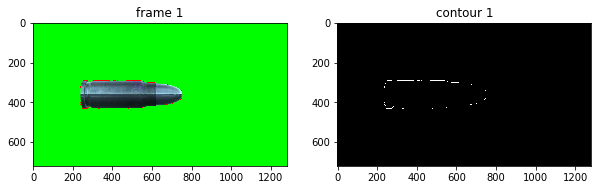

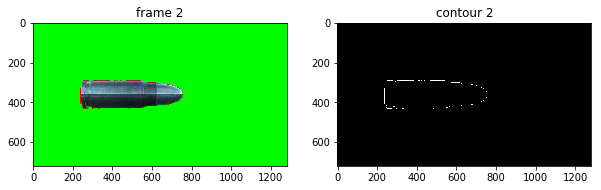

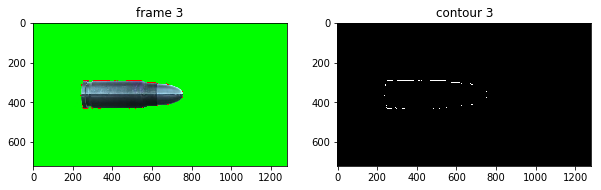

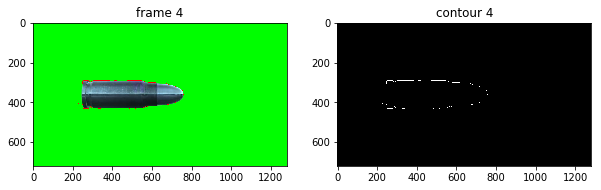

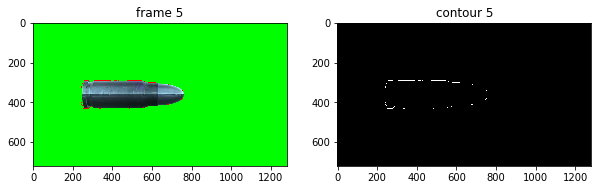

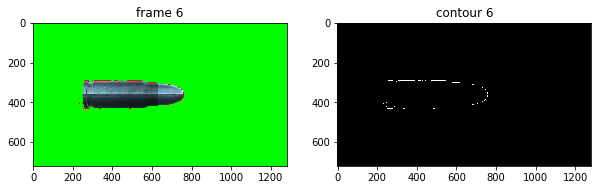

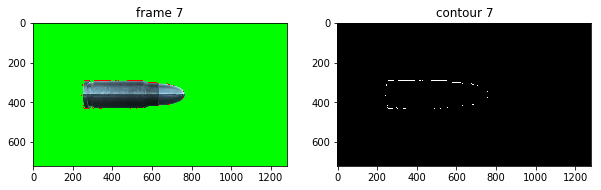

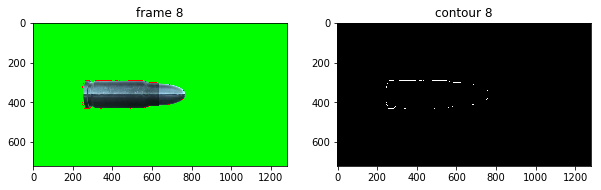

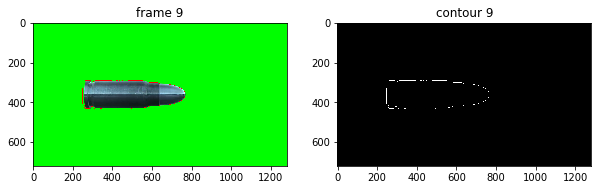

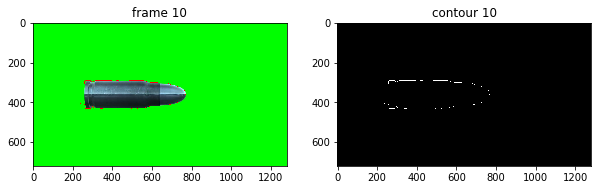

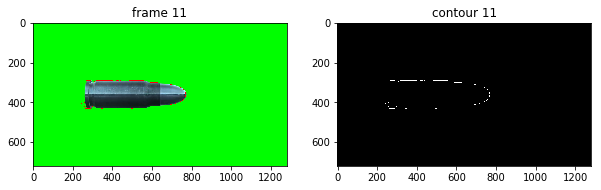

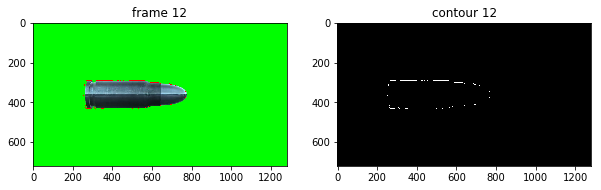

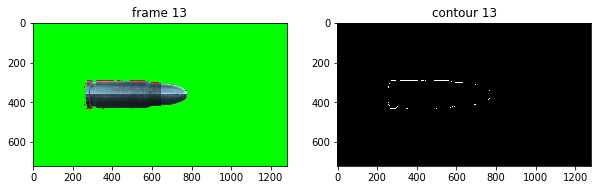

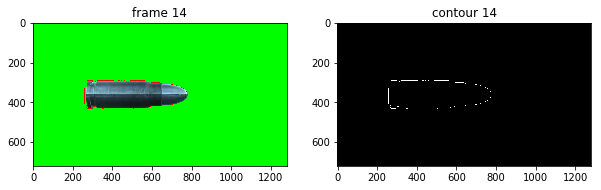

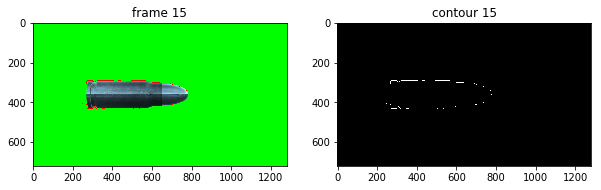

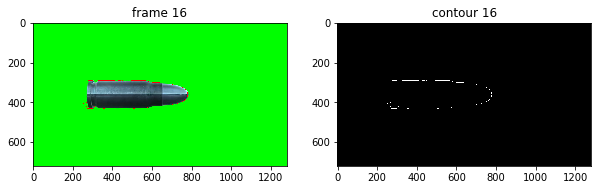

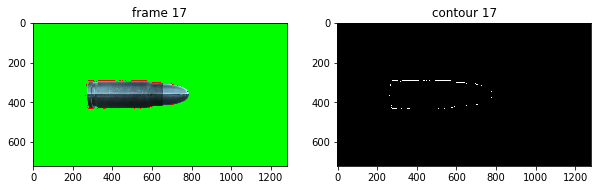

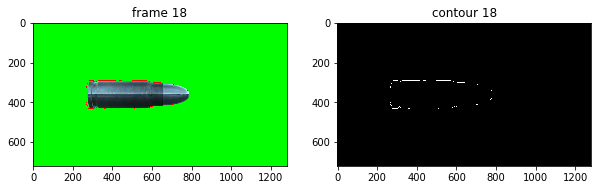

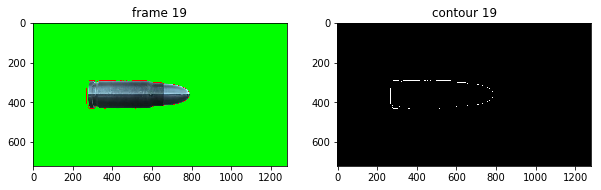

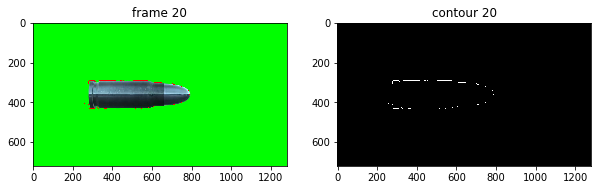

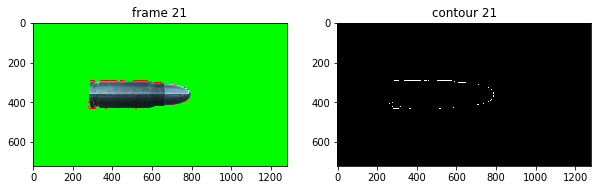

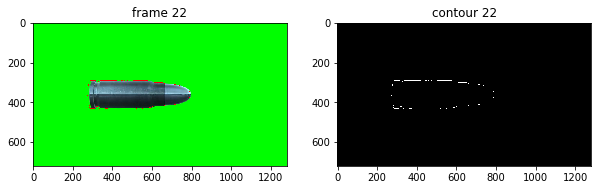

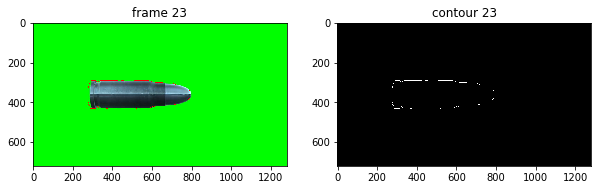

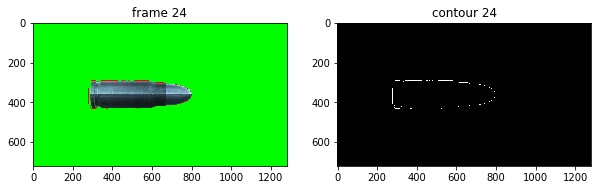

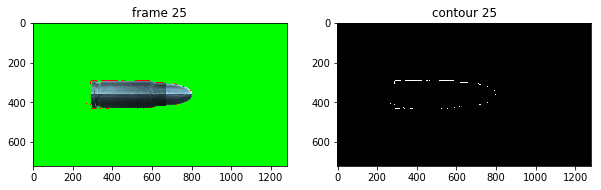

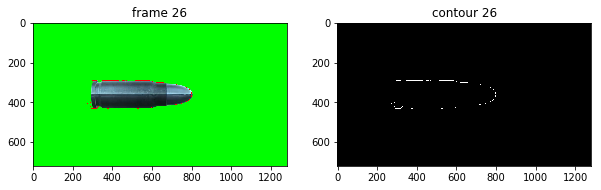

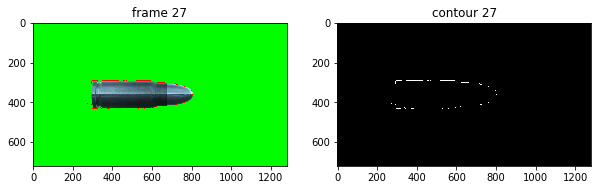

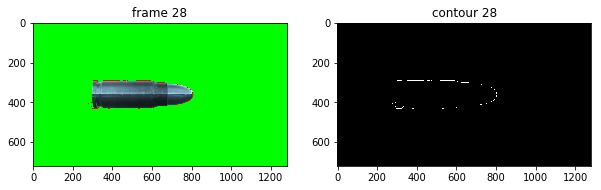

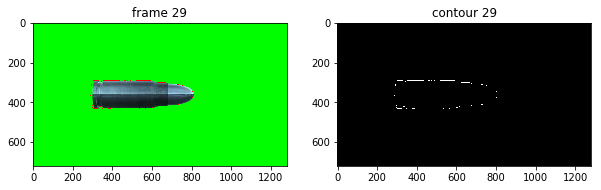

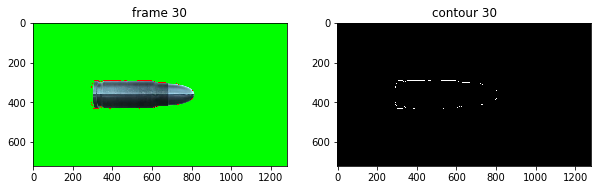

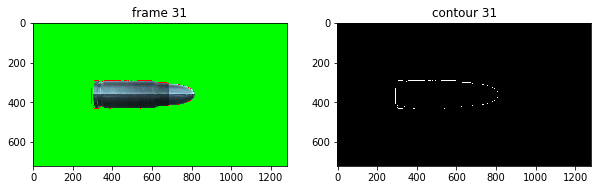

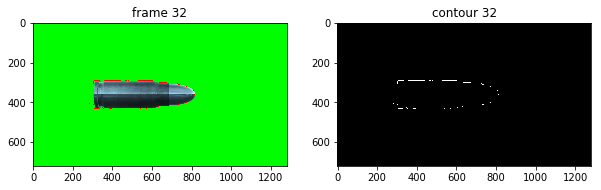

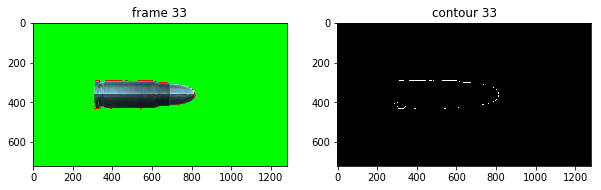

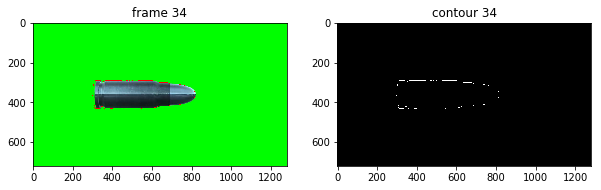

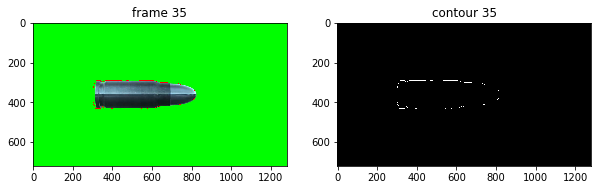

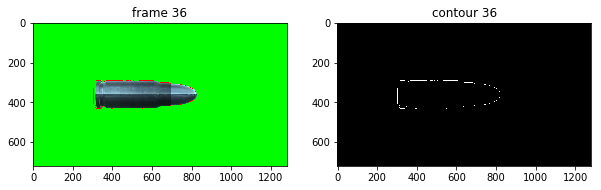

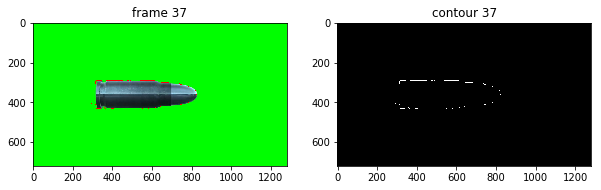

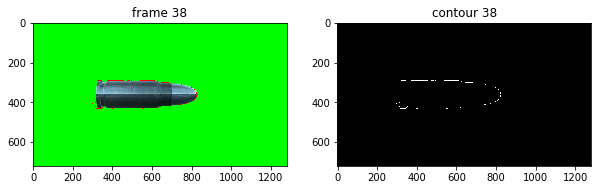

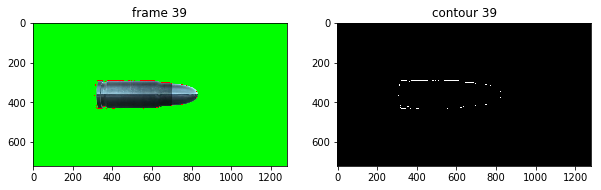

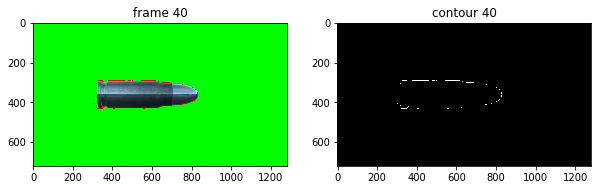

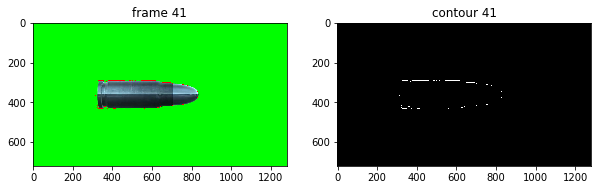

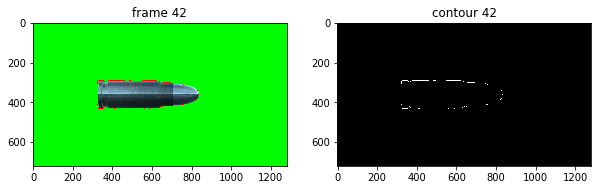

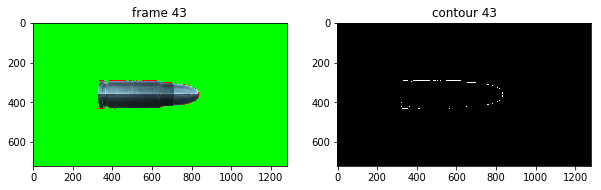

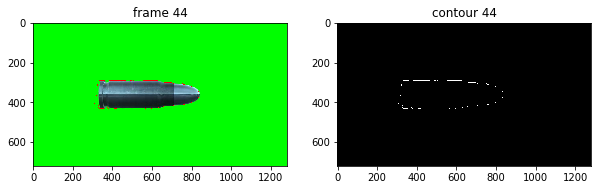

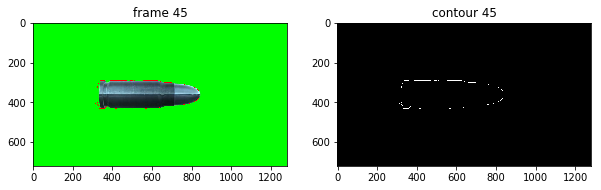

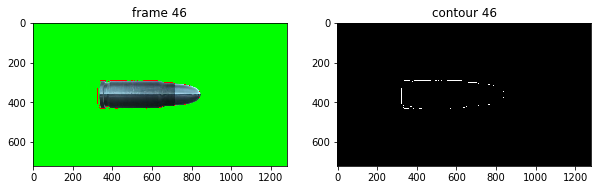

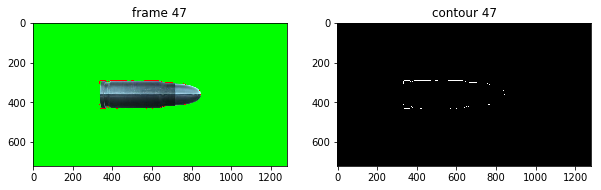

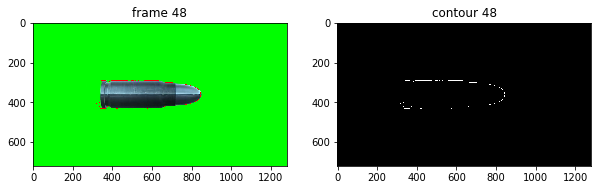

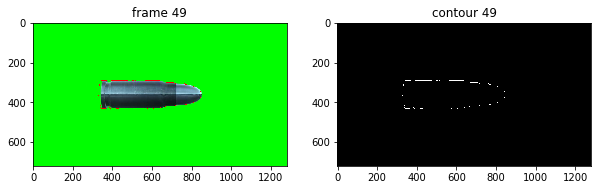

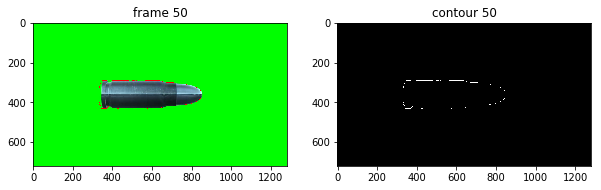

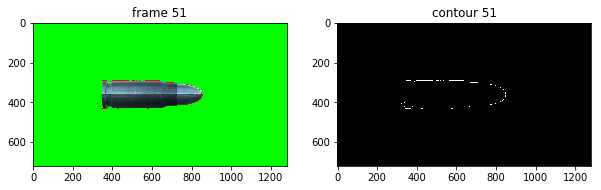

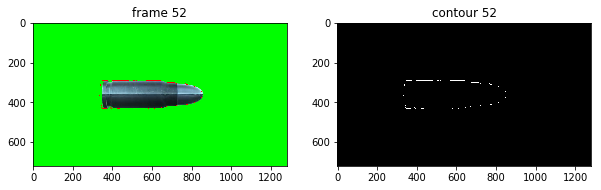

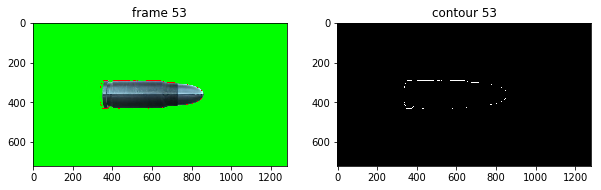

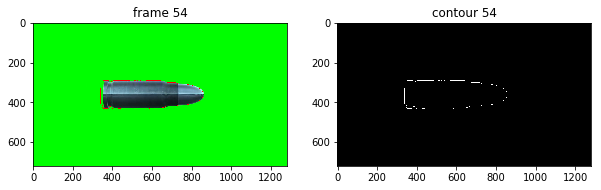

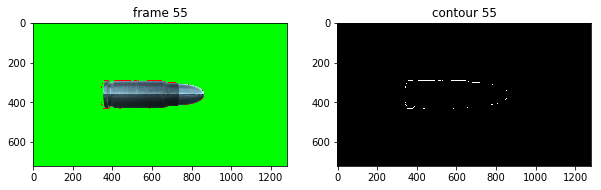

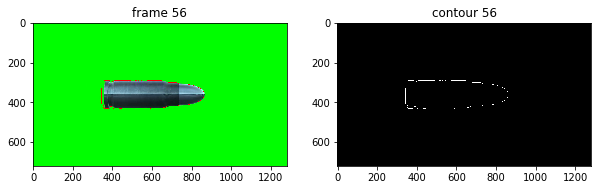

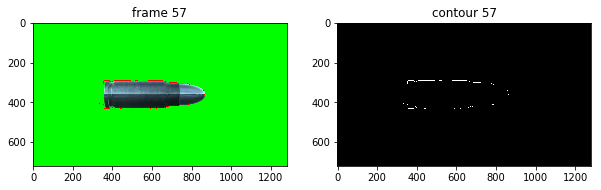

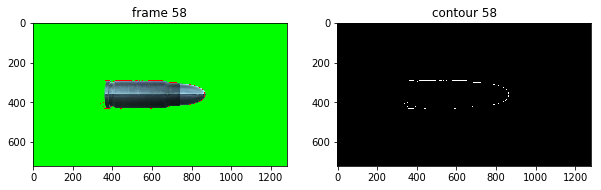

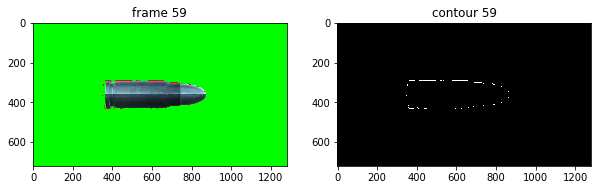

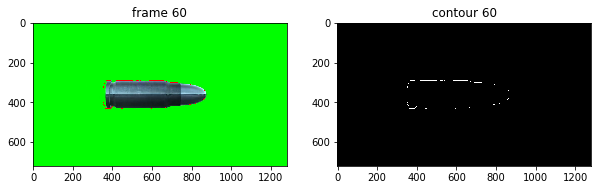

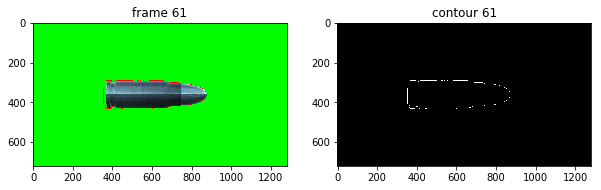

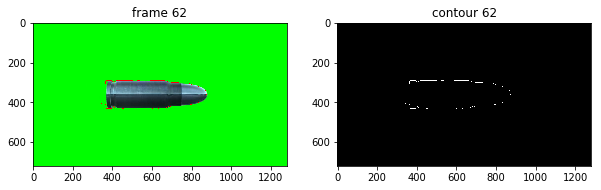

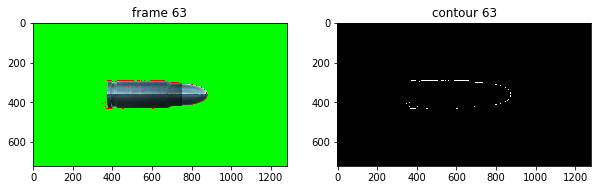

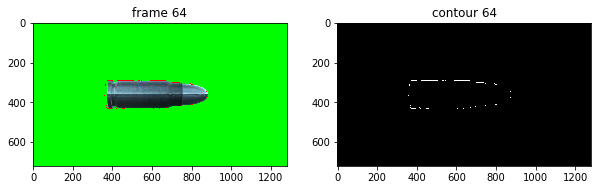

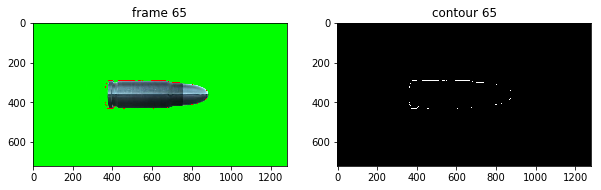

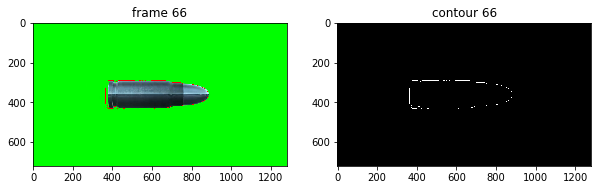

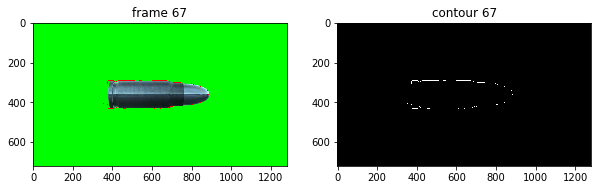

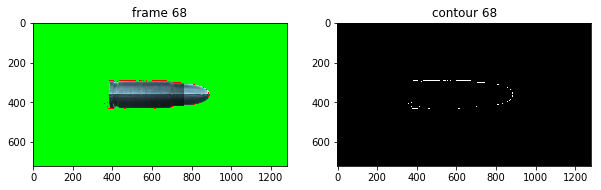

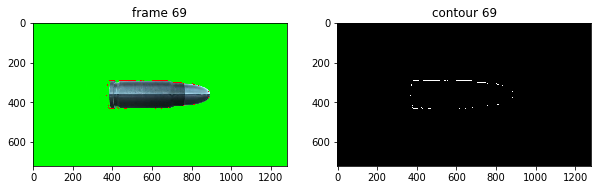

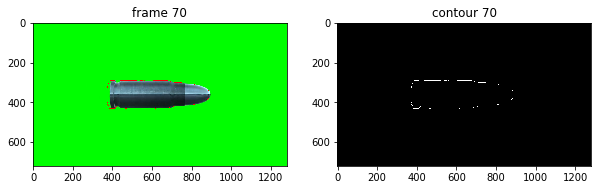

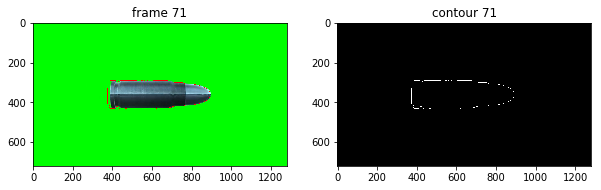

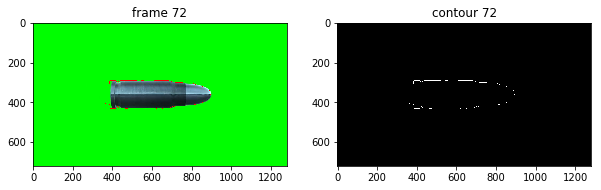

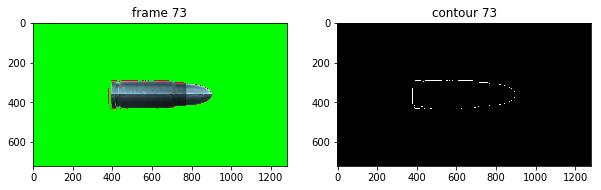

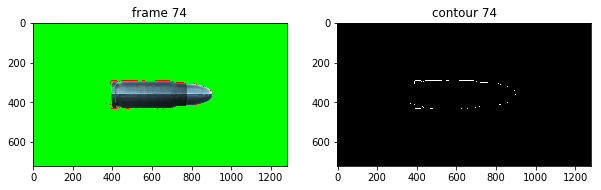

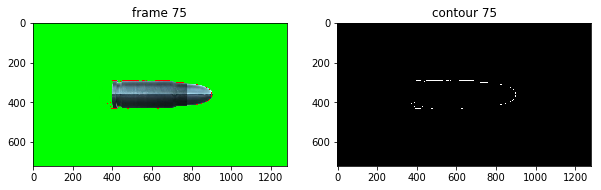

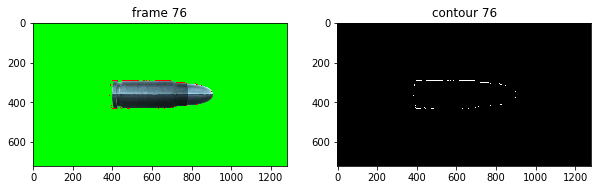

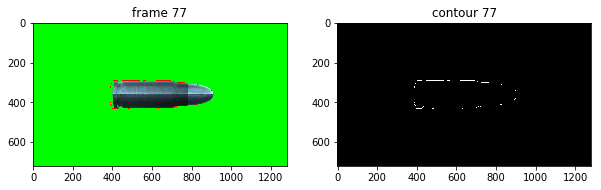

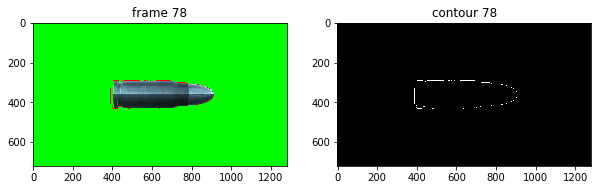

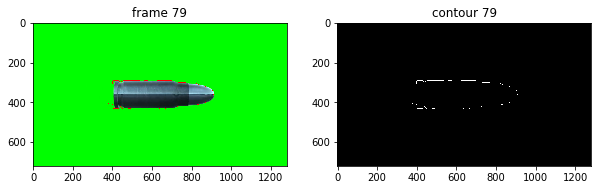

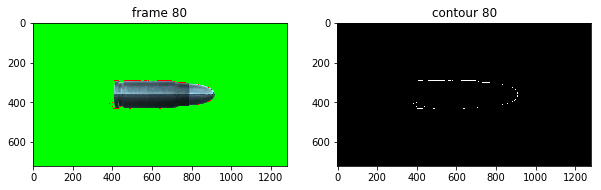

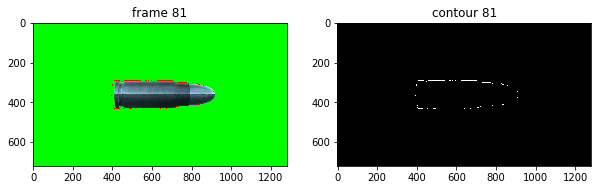

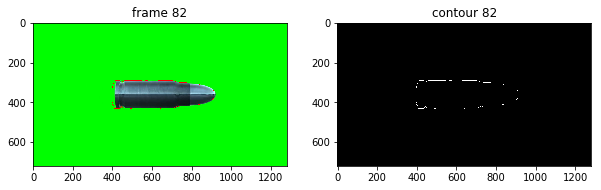

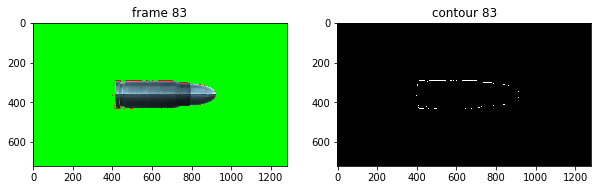

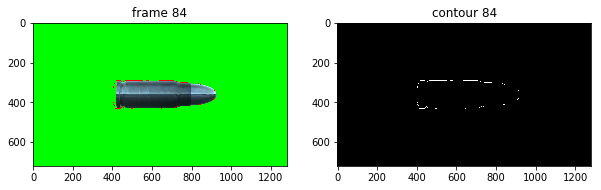

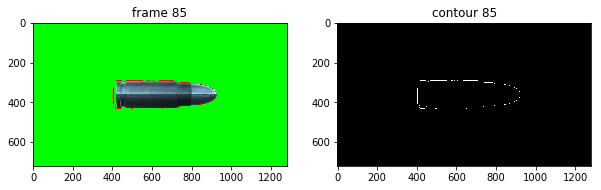

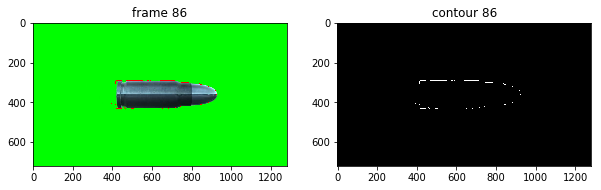

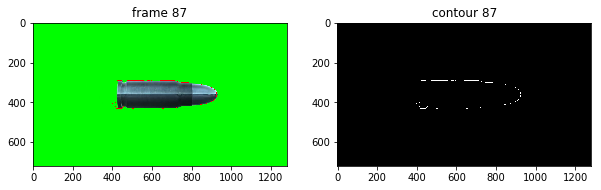

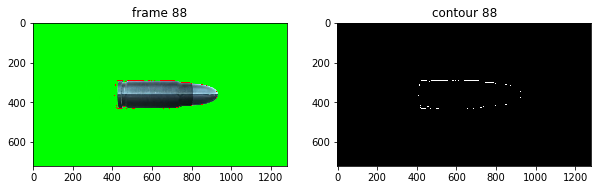

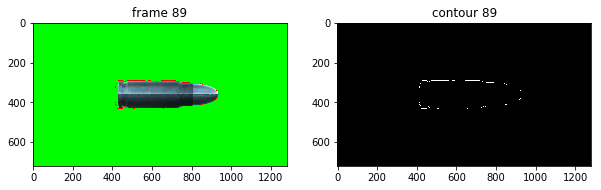

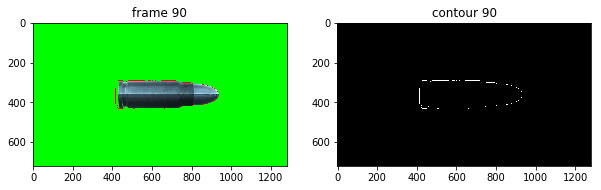

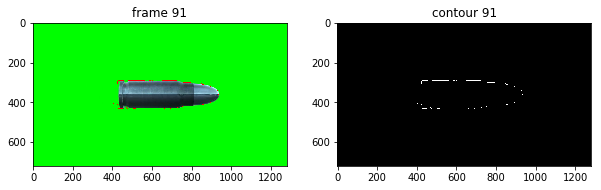

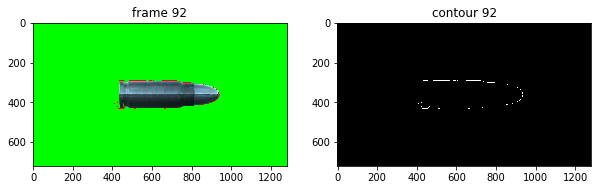

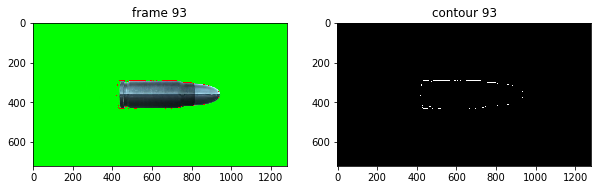

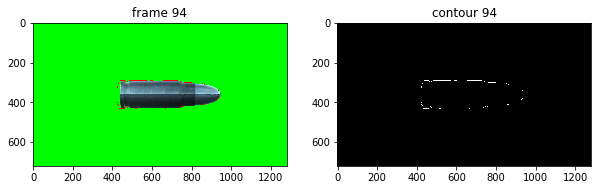

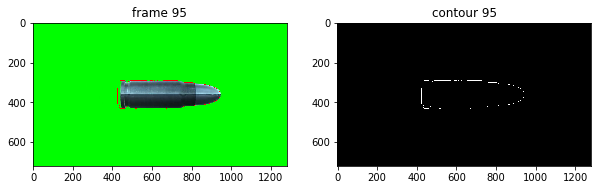

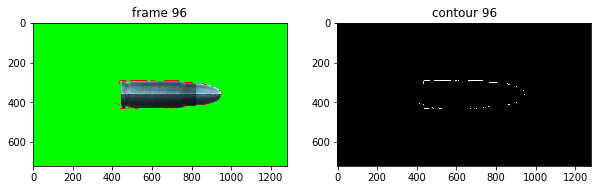

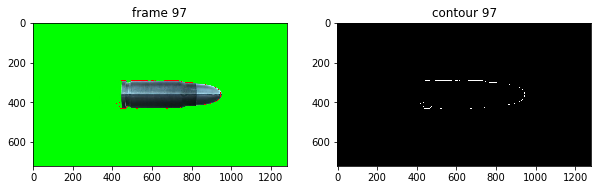

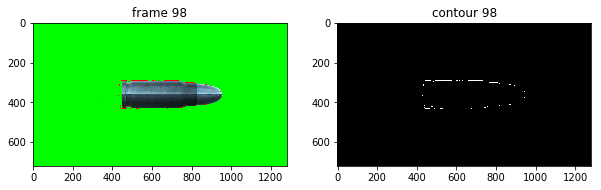

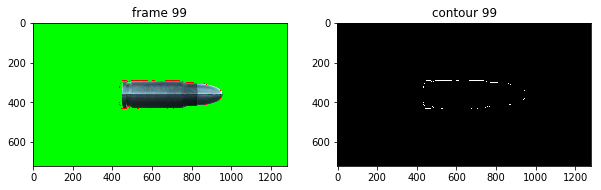

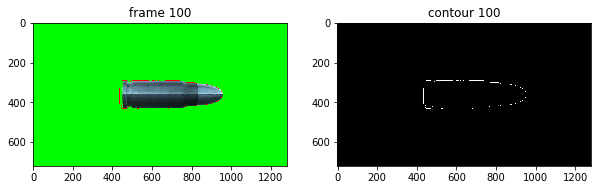

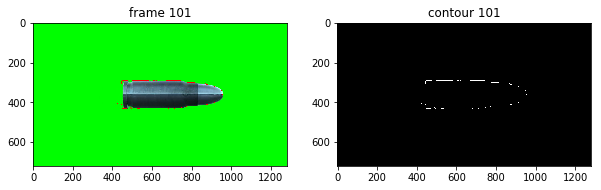

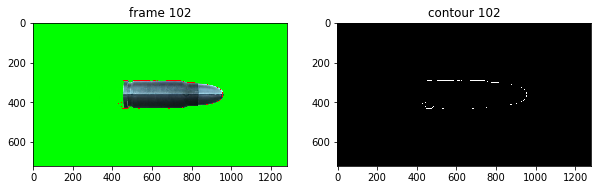

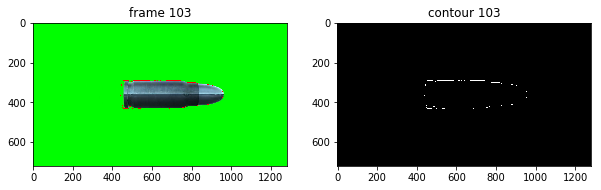

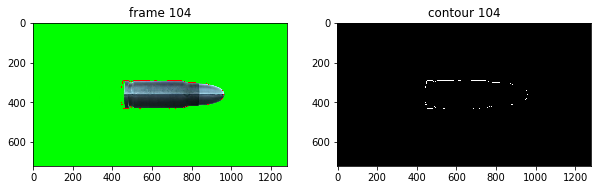

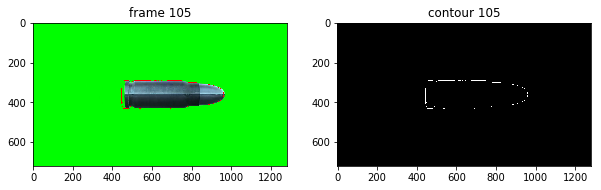

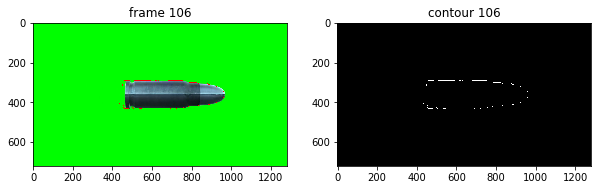

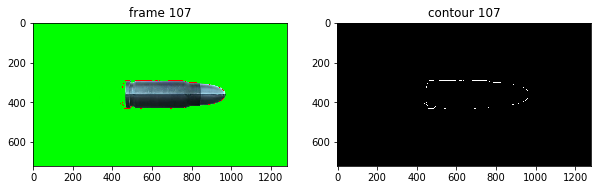

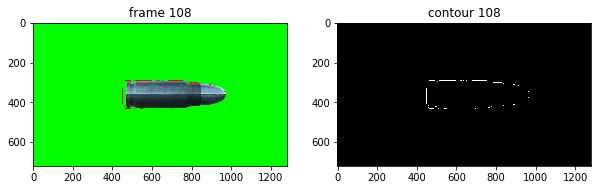

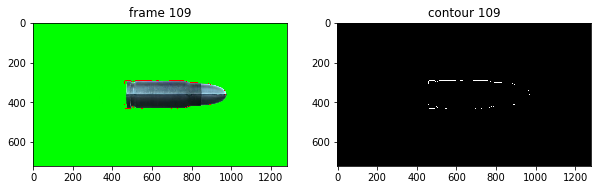

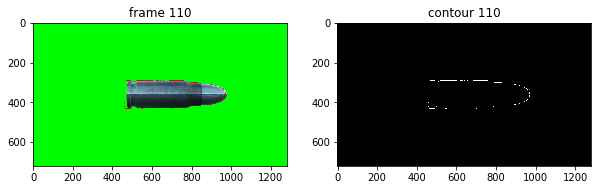

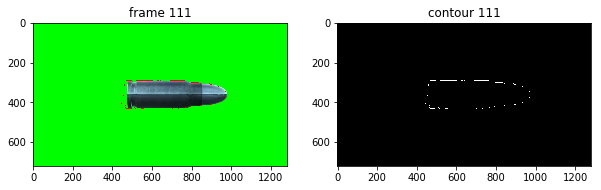

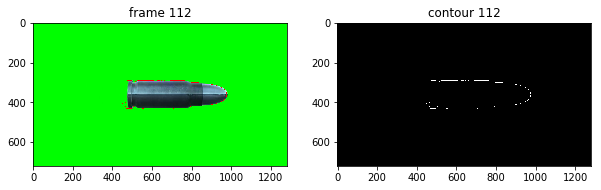

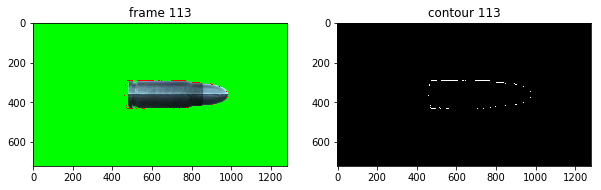

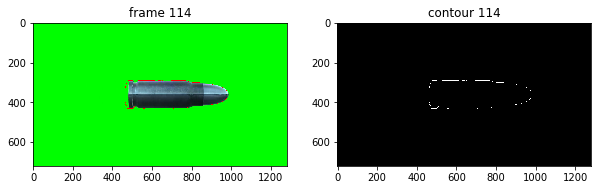

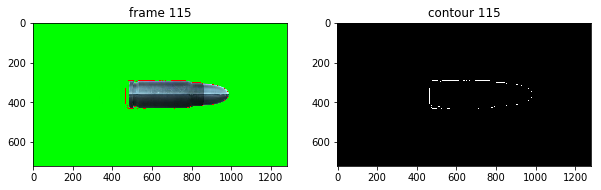

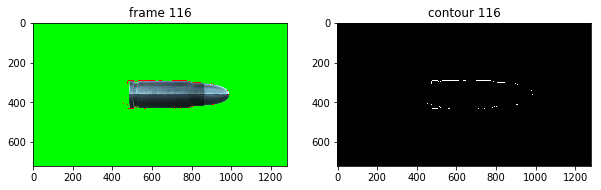

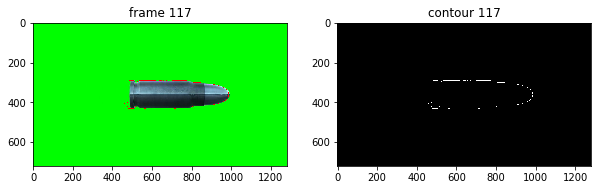

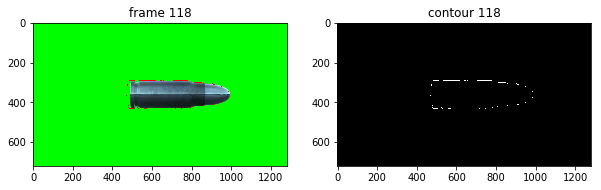

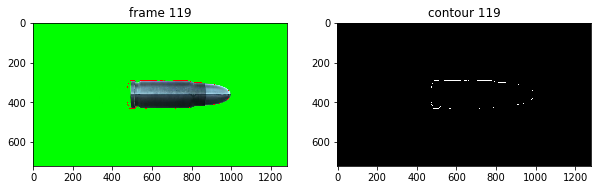

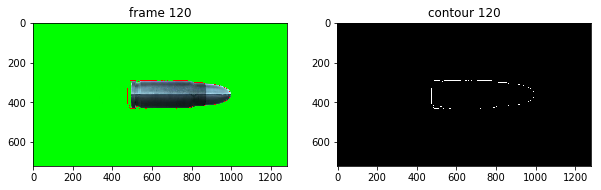

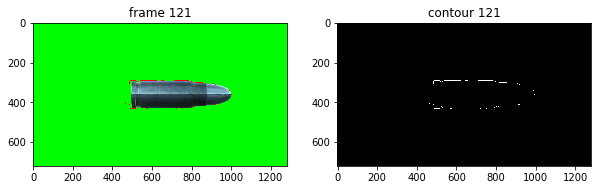

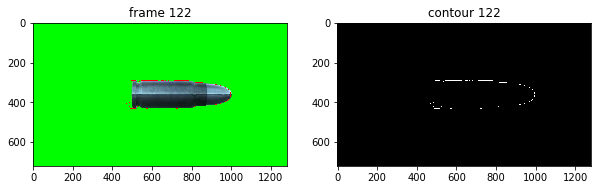

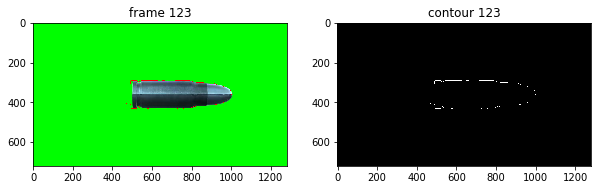

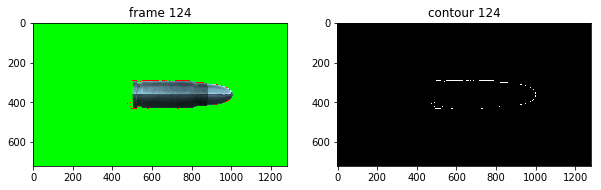

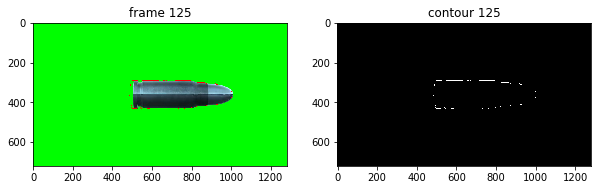

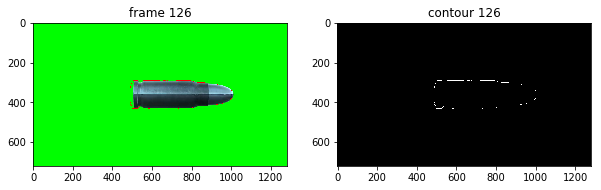

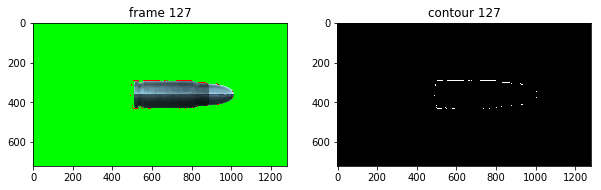

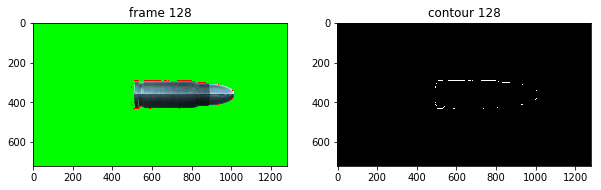

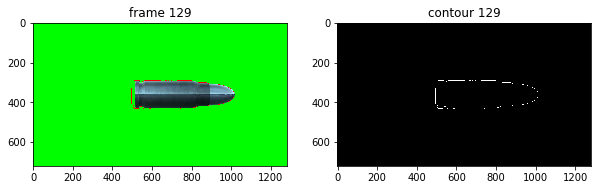

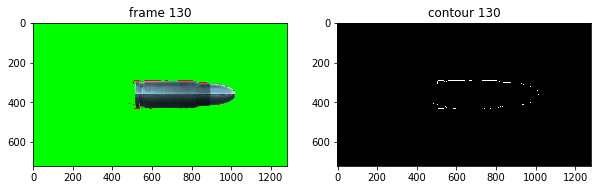

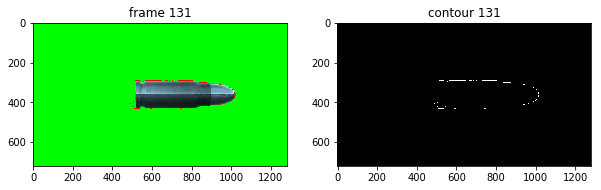

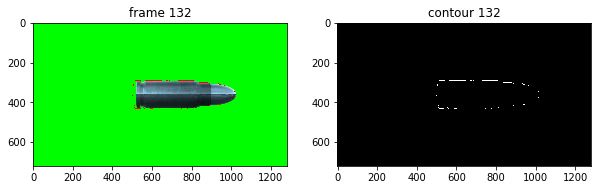

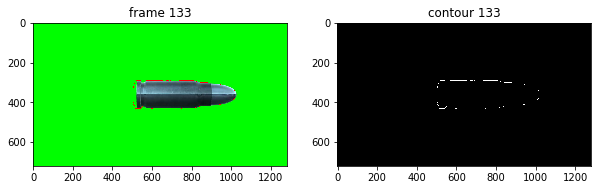

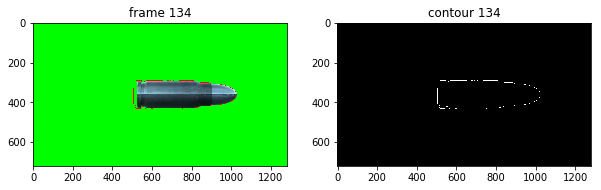

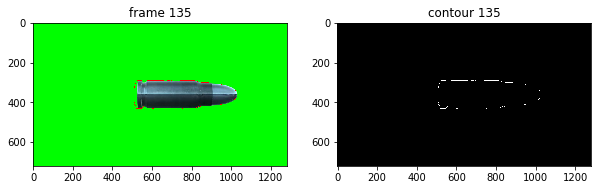

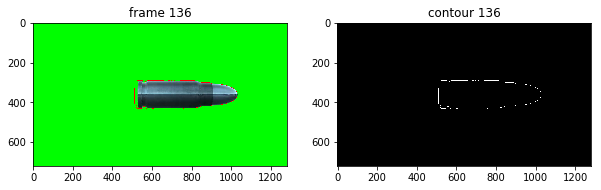

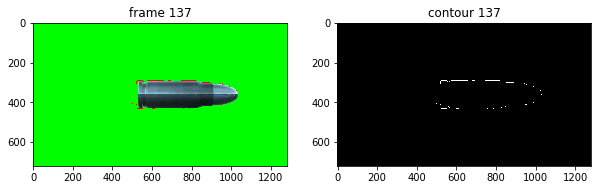

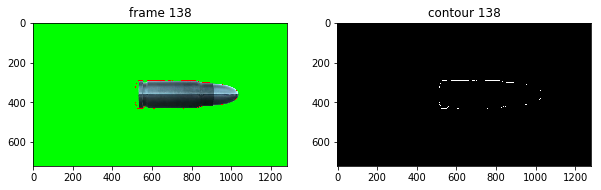

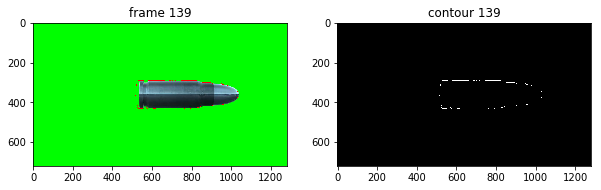

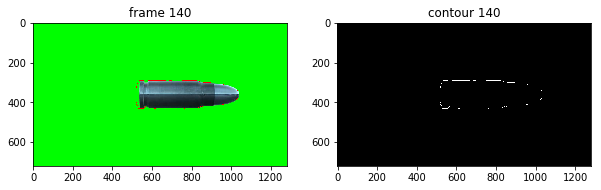

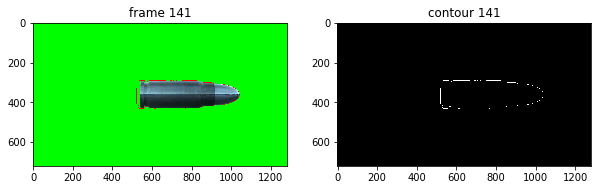

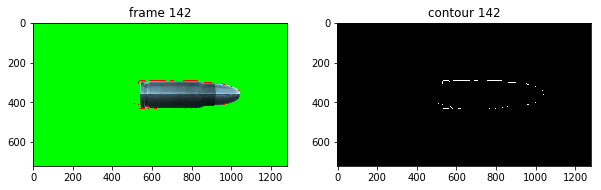

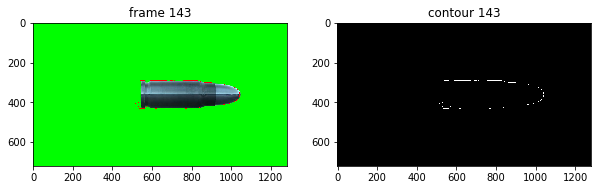

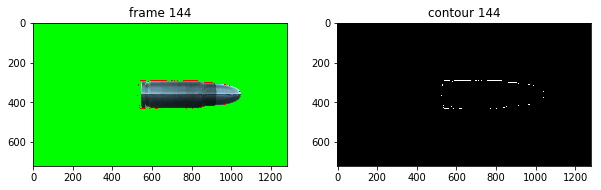

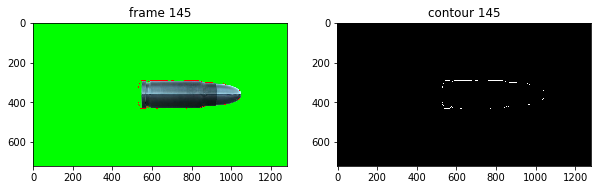

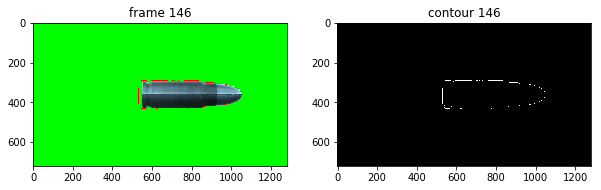

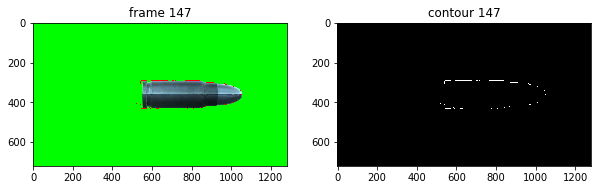

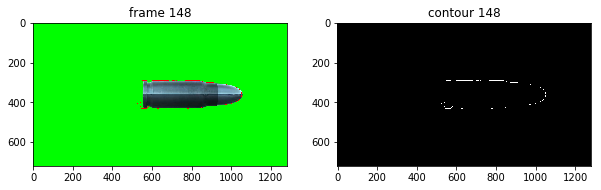

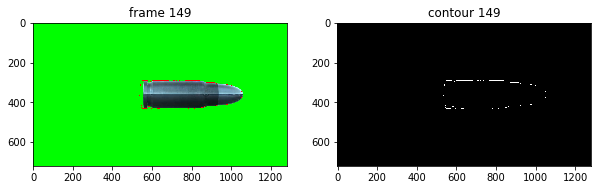

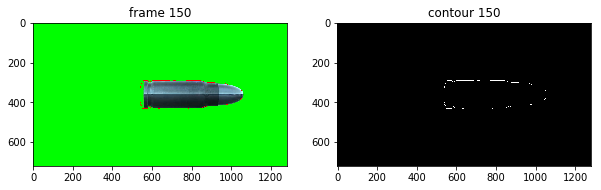

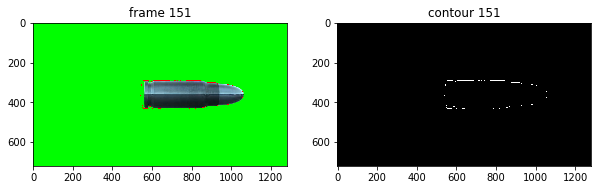

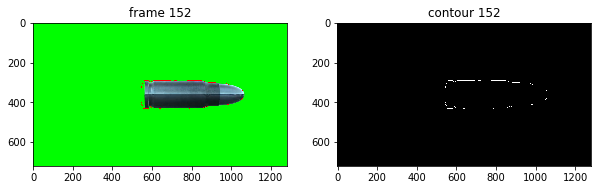

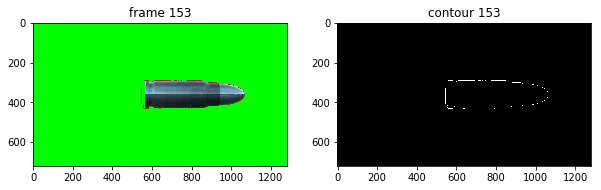

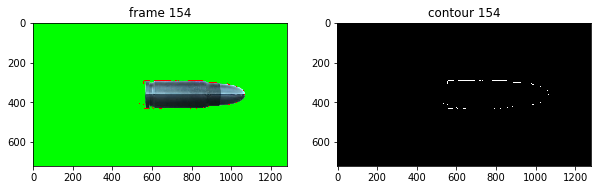

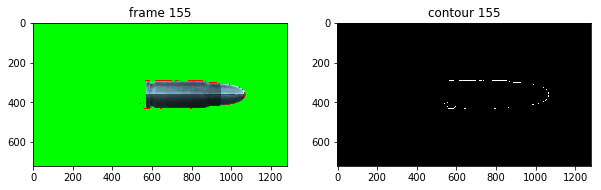

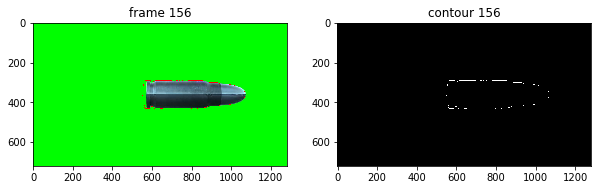

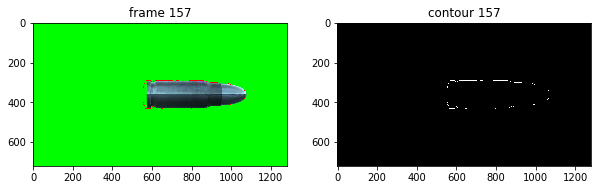

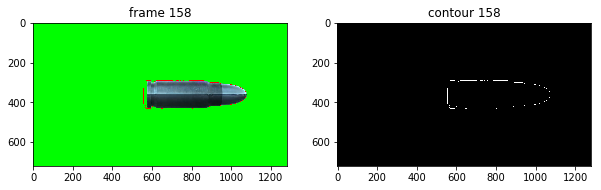

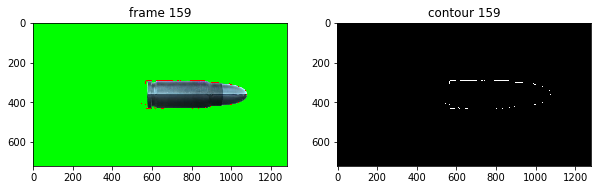

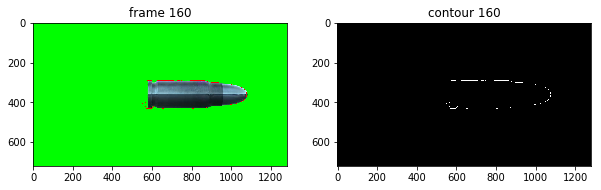

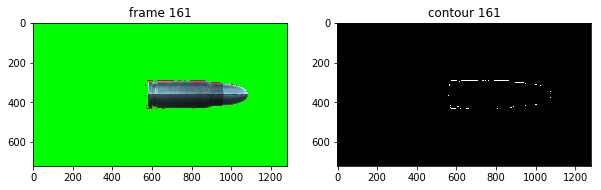

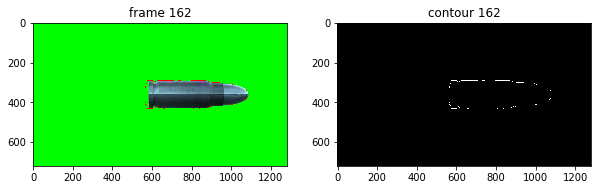

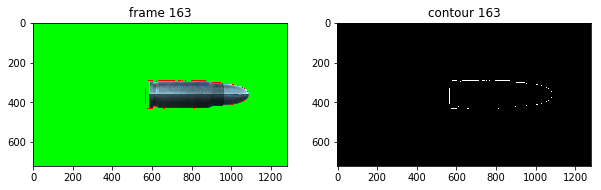

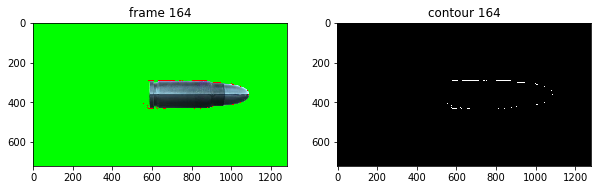

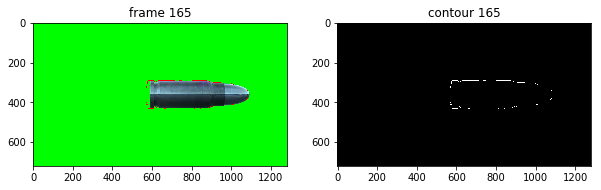

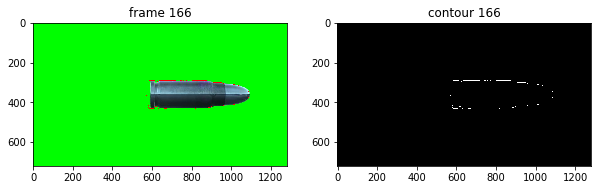

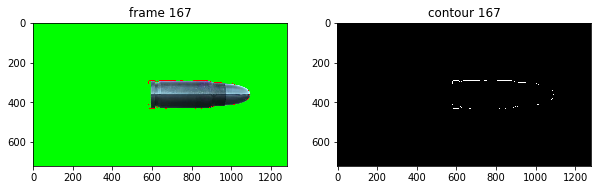

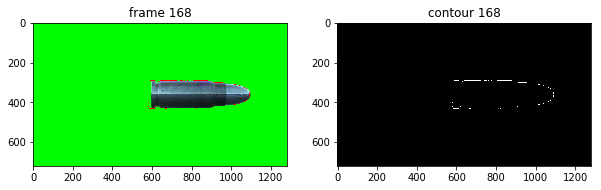

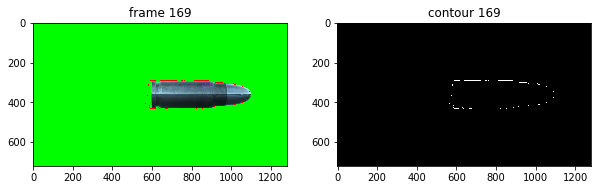

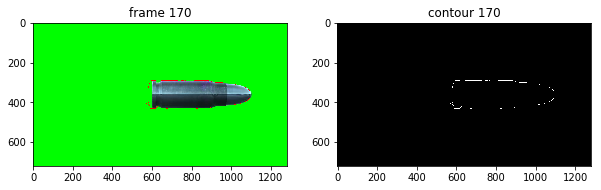

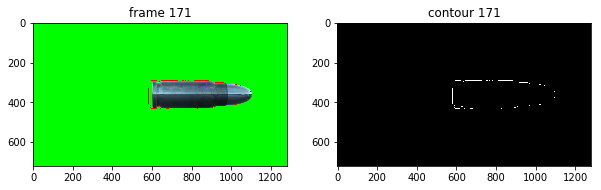

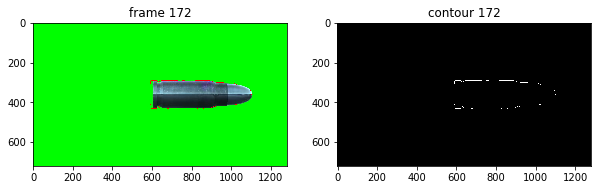

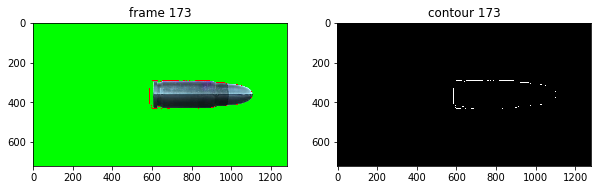

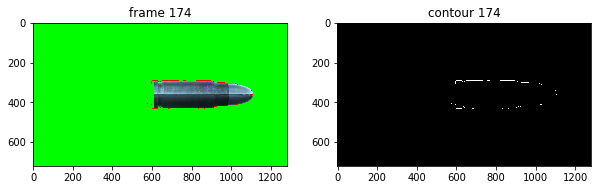

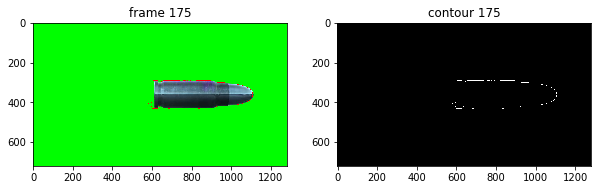

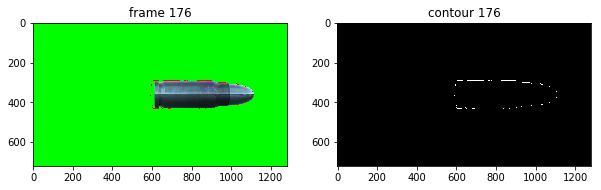

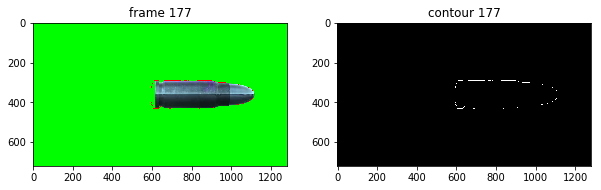

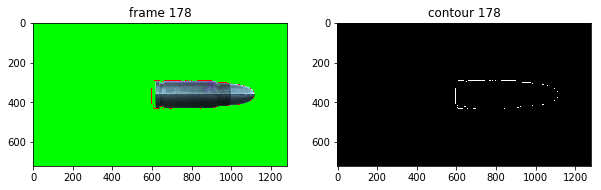

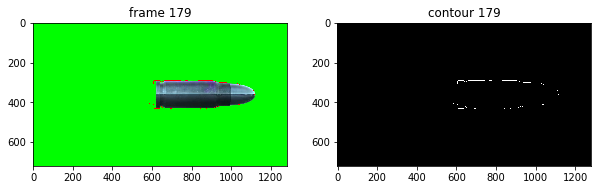

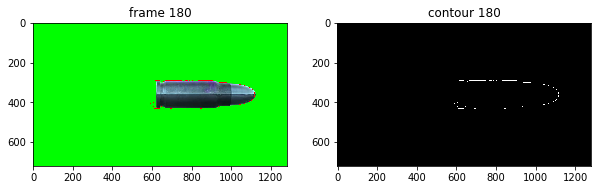

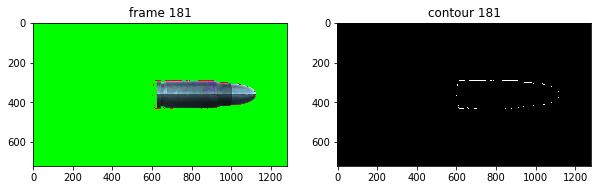

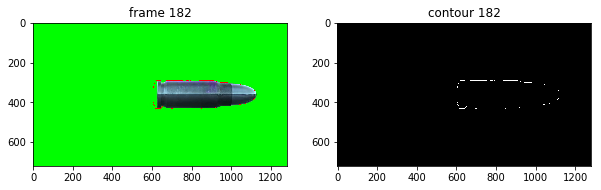

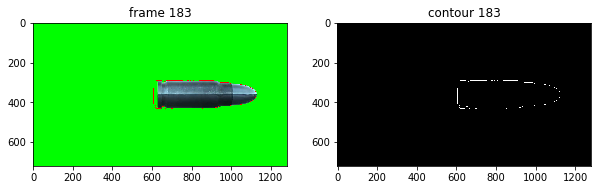

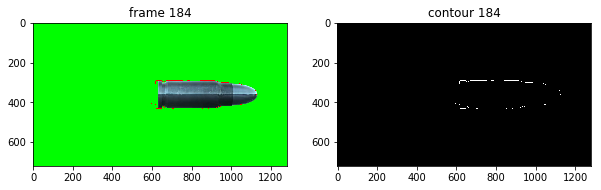

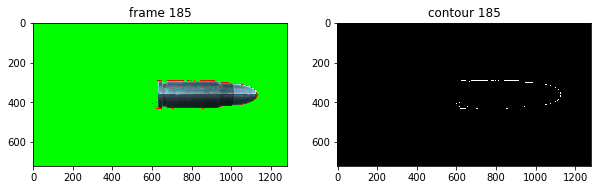

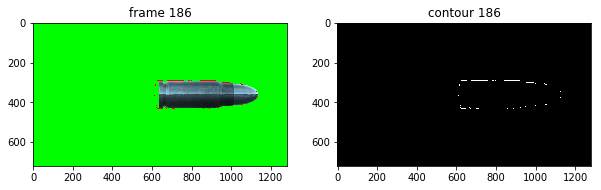

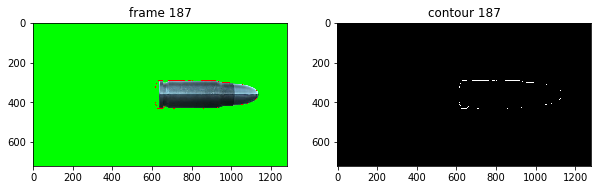

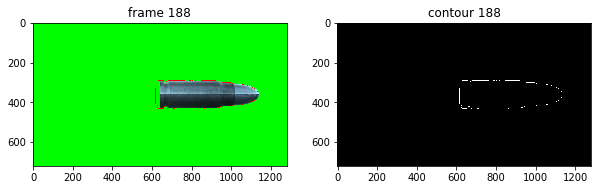

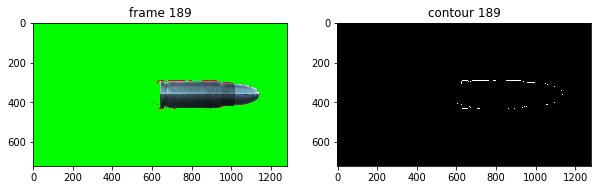

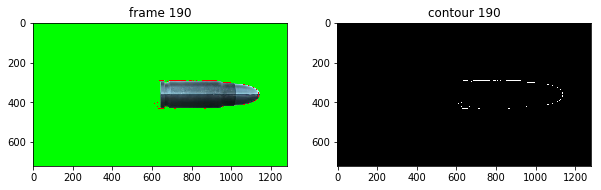

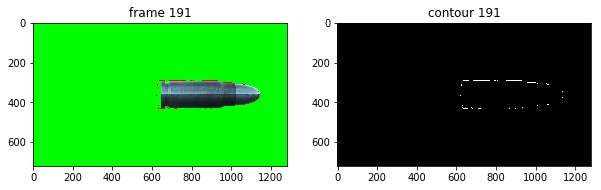

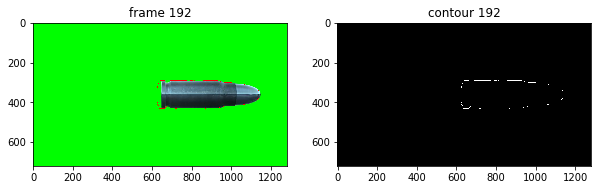

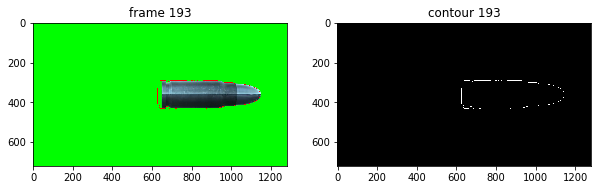

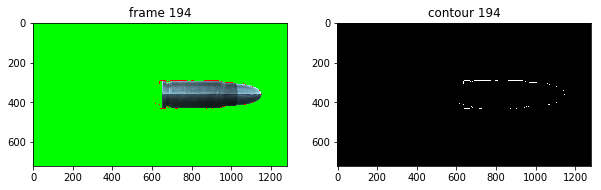

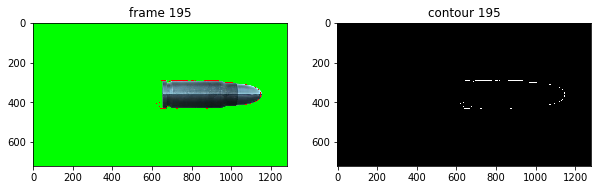

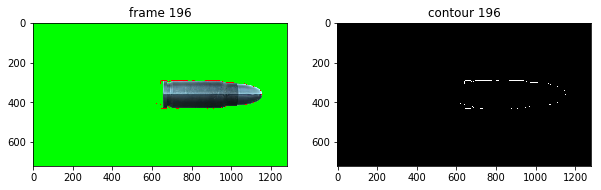

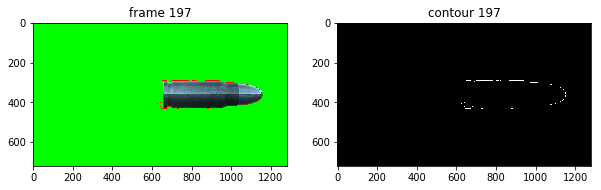

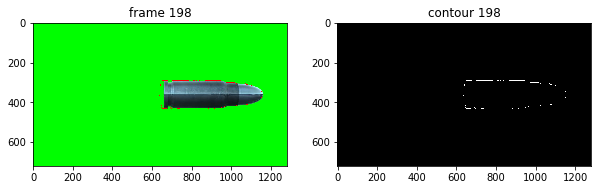

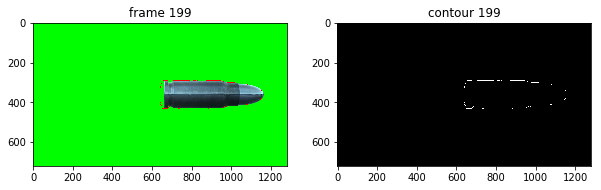

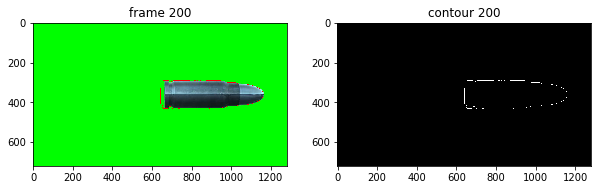

In [458]:
fois=0
while True and fois<nmax_frame:
    print(fois)
    fois+=1
    _,frame=video.read()
    pixels=ctr_pixels(ctr,nb_pixels_eval)
    n=nbr_deplacement(ctr,pixels,frame,frequence0,taille_inteval)
    ctr,frame=deplace_ctr(ctr,frame,n)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].set_title('frame '+str(fois))
    axes[0].imshow(frame)
    axes[1].set_title('contour '+str(fois))
    axes[1].imshow(ctr)